## Abstract
Understanding customer sentiments is of paramount importance in marketing strategies today. Not only will it give companies an insight as to how customers perceive their products and/or services, but it will also give them an idea on how to improve their offers. This paper attempts to understand the correlation of different variables in customer reviews on a women clothing e-commerce, and to classify each review whether it recommends the reviewed product or not and whether it consists of positive, negative, or neutral sentiment. To achieve these goals, we employed univariate and multivariate analyses on dataset features except for review titles and review texts, and we implemented a bidirectional recurrent neural network (RNN) with long-short term memory unit (LSTM) for recommendation and sentiment classification. Results have shown that a recommendation is a strong indicator of a positive sentiment score, and vice-versa. On the other hand, ratings in product reviews are fuzzy indicators of sentiment scores. We also found out that the bidirectional LSTM was able to reach an F1-score of 0.88 for recommendation classification, and 0.93 for sentiment classification.

Statistical Analysis on E-Commerce Reviews, with Sentiment Classification using Bidirectional Recurrent Neural Network (RNN)
===

This report is based on Nick Brooks' [report](https://www.kaggle.com/nicapotato/guided-numeric-and-text-exploration-e-commerce/notebook) on the same subject.

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_csv('WomensClothingECommerceReviews.csv')

In [3]:
for column in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[column].notnull()]
df.drop(df.columns[0], inplace=True, axis=1)

In [4]:
df.shape

(22628, 10)

In [5]:
df['Label'] = 0

In [6]:
df.loc[df.Rating >= 3, ['Label']] = 1

In [7]:
df['Word Count'] = df['Review Text'].str.split().apply(len)

In [8]:
df.sample(5)

Clothing ID  Age                    Title  \
8524           991   32                    Cheap   
15210         1033   36                      NaN   
15631          513   27      Wonderful one piece   
23241          862   53  Stylish and comfortable   
8398          1038   51      I love these jeans!   

                                             Review Text  Rating  \
8524   I loved the fit, color and style, but the fabr...       3   
15210  Super cute pants, fit and color just like mode...       4   
15631  I am very happy with this suit! it is gorgeous...       5   
23241  I love this top. very comfortable fabric and i...       5   
8398   These are so comfy. i will wear them for 3 sea...       5   

       Recommended IND  Positive Feedback Count   Division Name  \
8524                 0                        1         General   
15210                1                        0  General Petite   
15631                1                        1       Initmates   
23241                1                        1         General   
8398                 1                        0  General Petite   

      Department Name Class Name  Label  Word Count  
8524          Bottoms     Skirts      1          27  
15210         Bottoms      Jeans      1          74  
15631        Intimate       Swim      1          86  
23241            Tops      Knits      1          48  
8398          Bottoms      Jeans      1          18

In [9]:
df.describe().T.drop('count', axis=1)

mean         std   min    25%    50%     75%  \
Clothing ID              919.695908  201.683804   1.0  861.0  936.0  1078.0   
Age                       43.282880   12.328176  18.0   34.0   41.0    52.0   
Rating                     4.183092    1.115911   1.0    4.0    5.0     5.0   
Recommended IND            0.818764    0.385222   0.0    1.0    1.0     1.0   
Positive Feedback Count    2.631784    5.787520   0.0    0.0    1.0     3.0   
Label                      0.895263    0.306222   0.0    1.0    1.0     1.0   
Word Count                60.211950   28.533053   2.0   36.0   59.0    88.0   

                            max  
Clothing ID              1205.0  
Age                        99.0  
Rating                      5.0  
Recommended IND             1.0  
Positive Feedback Count   122.0  
Label                       1.0  
Word Count                115.0

In [10]:
df[['Title', 'Division Name', 'Department Name', 'Class Name']].describe(include=['O']).T.drop('count', axis=1)

unique       top   freq
Title            13983  Love it!    136
Division Name        3   General  13365
Department Name      6      Tops  10048
Class Name          20   Dresses   6145

# Univariate Distributions

## Age and Positive Feedback Frequency Distributions

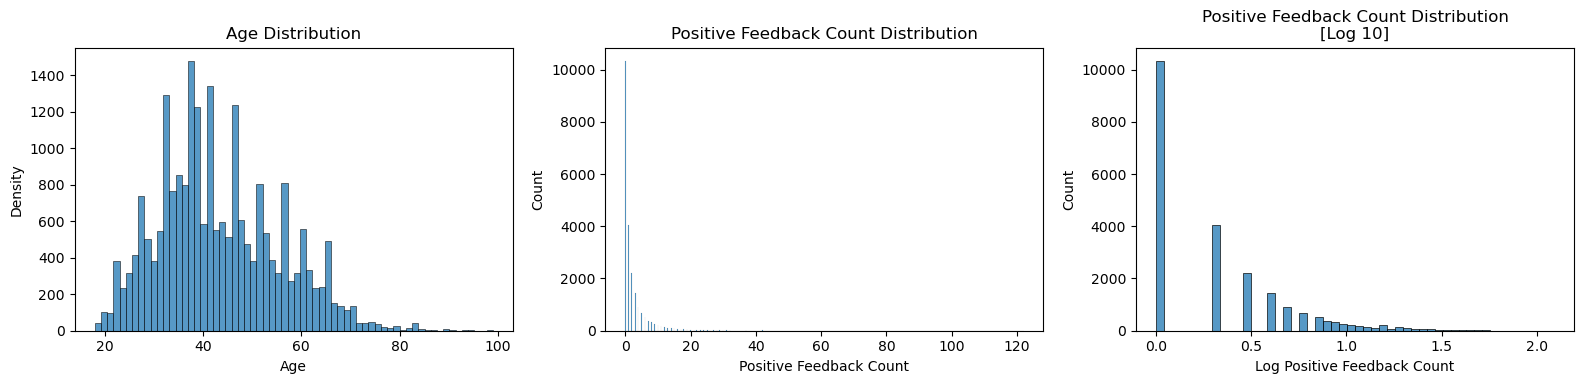

In [11]:
f, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=False)
sns.histplot(df.Age, ax=ax[0])
ax[0].set_title('Age Distribution')
ax[0].set_ylabel('Density')
sns.histplot(df['Positive Feedback Count'], ax=ax[1])
ax[1].set_title('Positive Feedback Count Distribution')
sns.histplot(np.log10((df['Positive Feedback Count'][df['Positive Feedback Count'].notnull()] + 1)), ax=ax[2])
ax[2].set_title('Positive Feedback Count Distribution\n[Log 10]')
ax[2].set_xlabel('Log Positive Feedback Count')
plt.rcParams.update({'font.size': 12})
plt.tight_layout()
plt.savefig('age-and-positive-feedback-freqdist.png', format='png', dpi=600)
plt.show()

## Division Name and Department Name Distributions

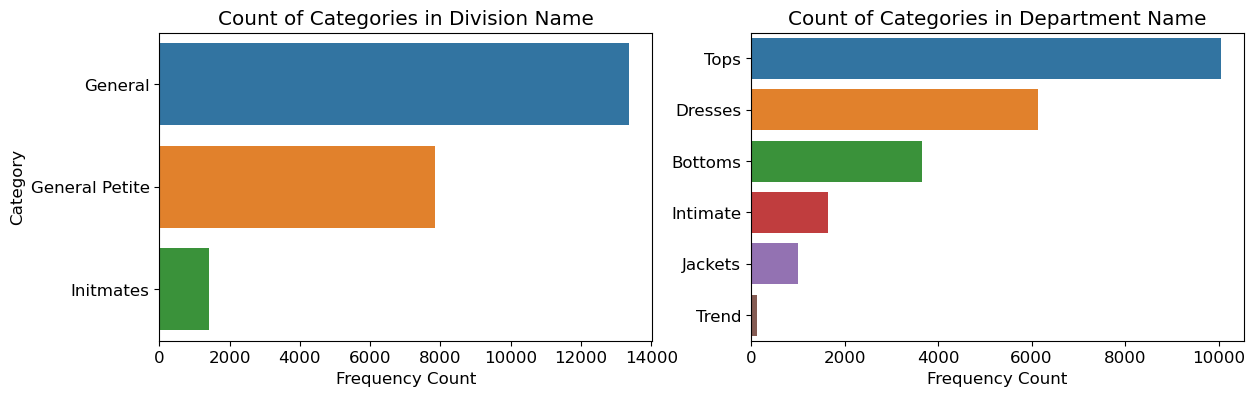

In [12]:
row_plots = ['Division Name', 'Department Name']
f, axes = plt.subplots(1, len(row_plots), figsize=(14, 4), sharex=False)

for i, x in enumerate(row_plots):
    sns.countplot(y=x, data=df, order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title('Count of Categories in {}'.format(x))
    axes[i].set_xlabel('')
    axes[i].set_xlabel('Frequency Count')
axes[0].set_ylabel('Category')
axes[1].set_ylabel('')
plt.savefig('divname-and-deptname-freqdist.png', format='png', dpi=600)
plt.show()

## Clothing ID Frequency Distribution

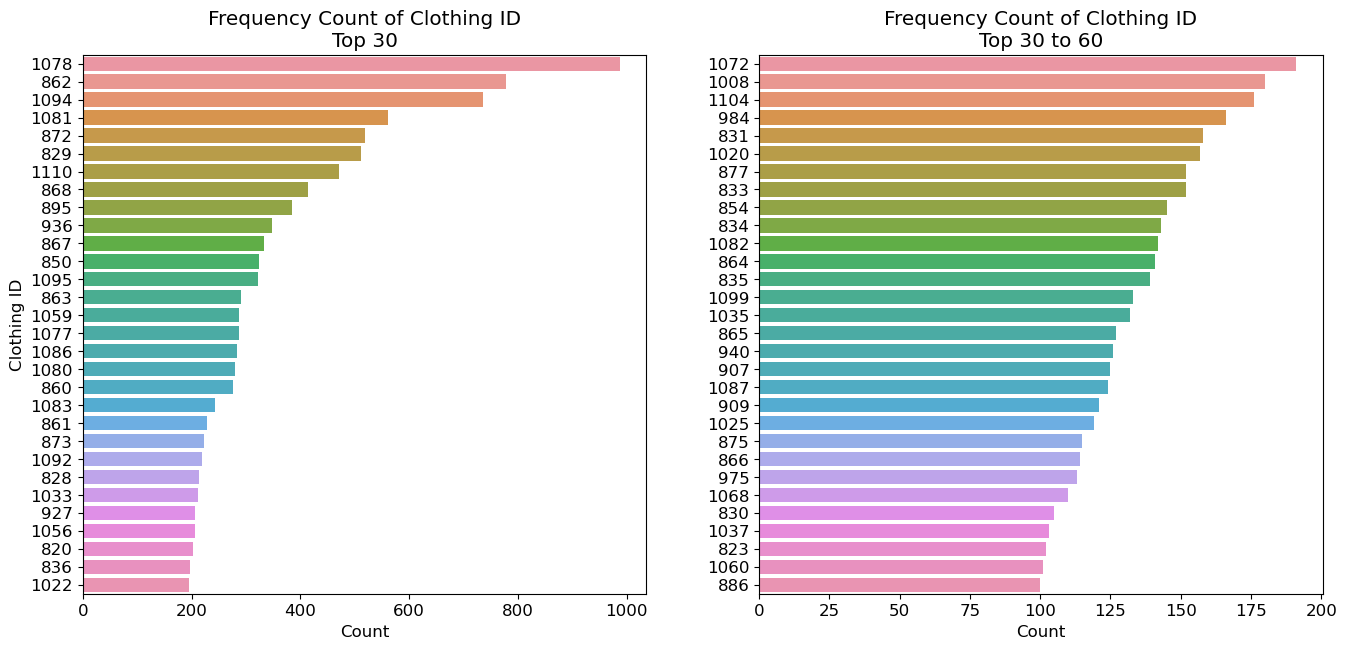

Dataframe Dimension: 22628 Rows


mean         std    min    25%     50%     75%  \
Clothing ID              1015.4848  103.396022  862.0  862.0  1078.0  1094.0   
Age                        42.7248   12.150429   18.0   34.0    41.0    51.0   
Rating                      4.1892    1.104306    1.0    4.0     5.0     5.0   
Recommended IND             0.8184    0.385592    0.0    1.0     1.0     1.0   
Positive Feedback Count     2.8624    6.773021    0.0    0.0     1.0     3.0   
Label                       0.9024    0.296832    0.0    1.0     1.0     1.0   
Word Count                 60.5912   28.731486    2.0   36.0    60.0    89.0   

                            max  
Clothing ID              1094.0  
Age                        99.0  
Rating                      5.0  
Recommended IND             1.0  
Positive Feedback Count    98.0  
Label                       1.0  
Word Count                115.0

In [13]:
# Clothing ID Category
f, axes = plt.subplots(1, 2, figsize=[16, 7])
num = 30
sns.countplot(y='Clothing ID', data=df[df['Clothing ID'].isin(df['Clothing ID'].value_counts()[:num].index)],
              order= df['Clothing ID'].value_counts()[:num].index, ax=axes[0])
axes[0].set_title('Frequency Count of Clothing ID\nTop 30')
axes[0].set_xlabel('Count')

sns.countplot(y='Clothing ID', data=df[df['Clothing ID'].isin(df['Clothing ID'].value_counts()[num:60].index)],
              order=df['Clothing ID'].value_counts()[num:60].index, ax=axes[1])
axes[1].set_title('Frequency Count of Clothing ID\nTop 30 to 60')
axes[1].set_ylabel('')
axes[1].set_xlabel('Count')
plt.savefig('freqdist-clothingid-top60.png', format='png', dpi=600)
plt.show()

print('Dataframe Dimension: {} Rows'.format(df.shape[0]))
df[df['Clothing ID'].isin([1078, 862,1094])].describe().T.drop('count',axis=1)

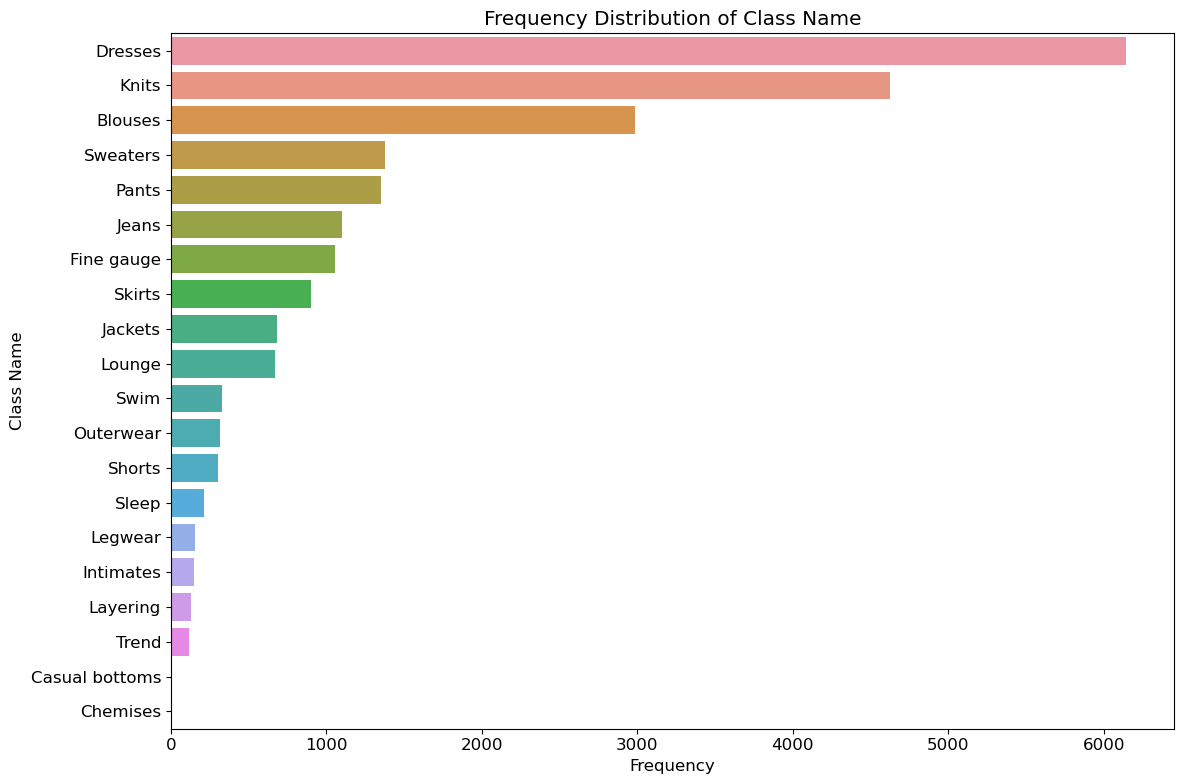

In [14]:
# Class Name
plt.subplots(figsize=(12, 8))
sns.countplot(y='Class Name', data=df,order=df['Class Name'].value_counts().index)
plt.title('Frequency Distribution of Class Name')
plt.xlabel('Frequency')
plt.tight_layout()
plt.savefig('freqdist-classname.png', format='png', dpi=300)
plt.show()

## Frequency Distribution of Rating, Recommended IND, and Label

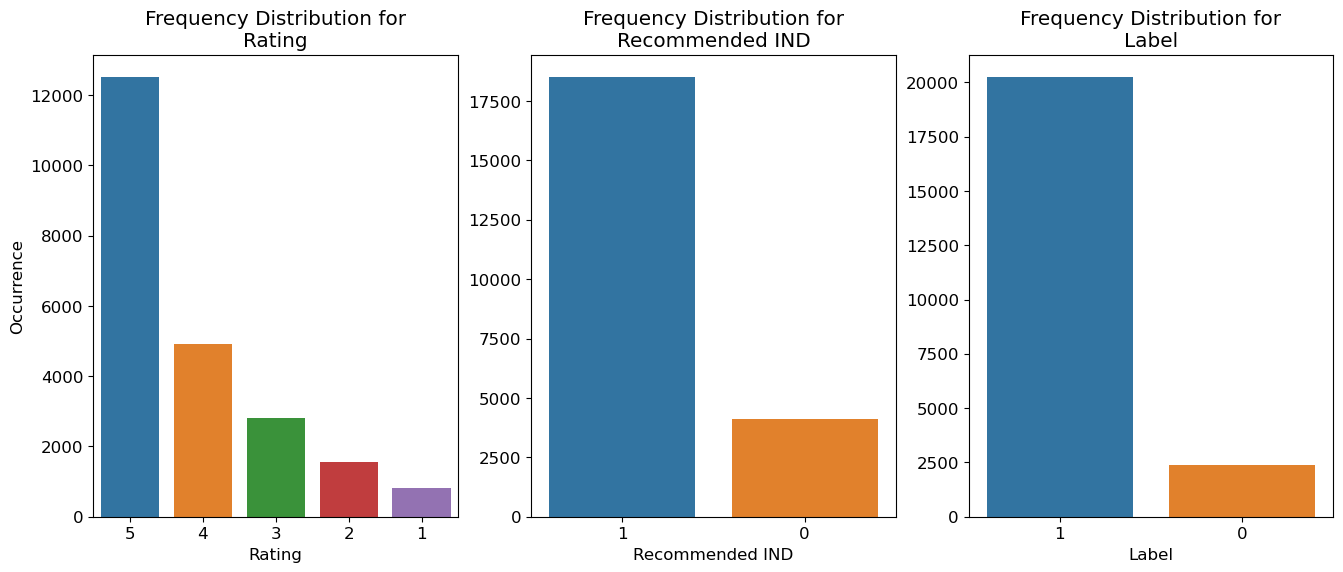

In [15]:
cat_dtypes = ['Rating', 'Recommended IND', 'Label']
increment = 0
f, axes = plt.subplots(1, len(cat_dtypes), figsize=(16, 6), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment], data=df, order=df[cat_dtypes[increment]].value_counts().index, ax=axes[i])
    axes[i].set_title('Frequency Distribution for\n{}'.format(cat_dtypes[increment]))
    axes[i].set_ylabel('Occurrence')
    axes[i].set_xlabel('{}'.format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel('')
axes[2].set_ylabel('')
plt.savefig('freqdist-rating-recommended-label.png', format='png', dpi=300)
plt.show()

## Word Count by Rating, Department Name, and Recommended IND

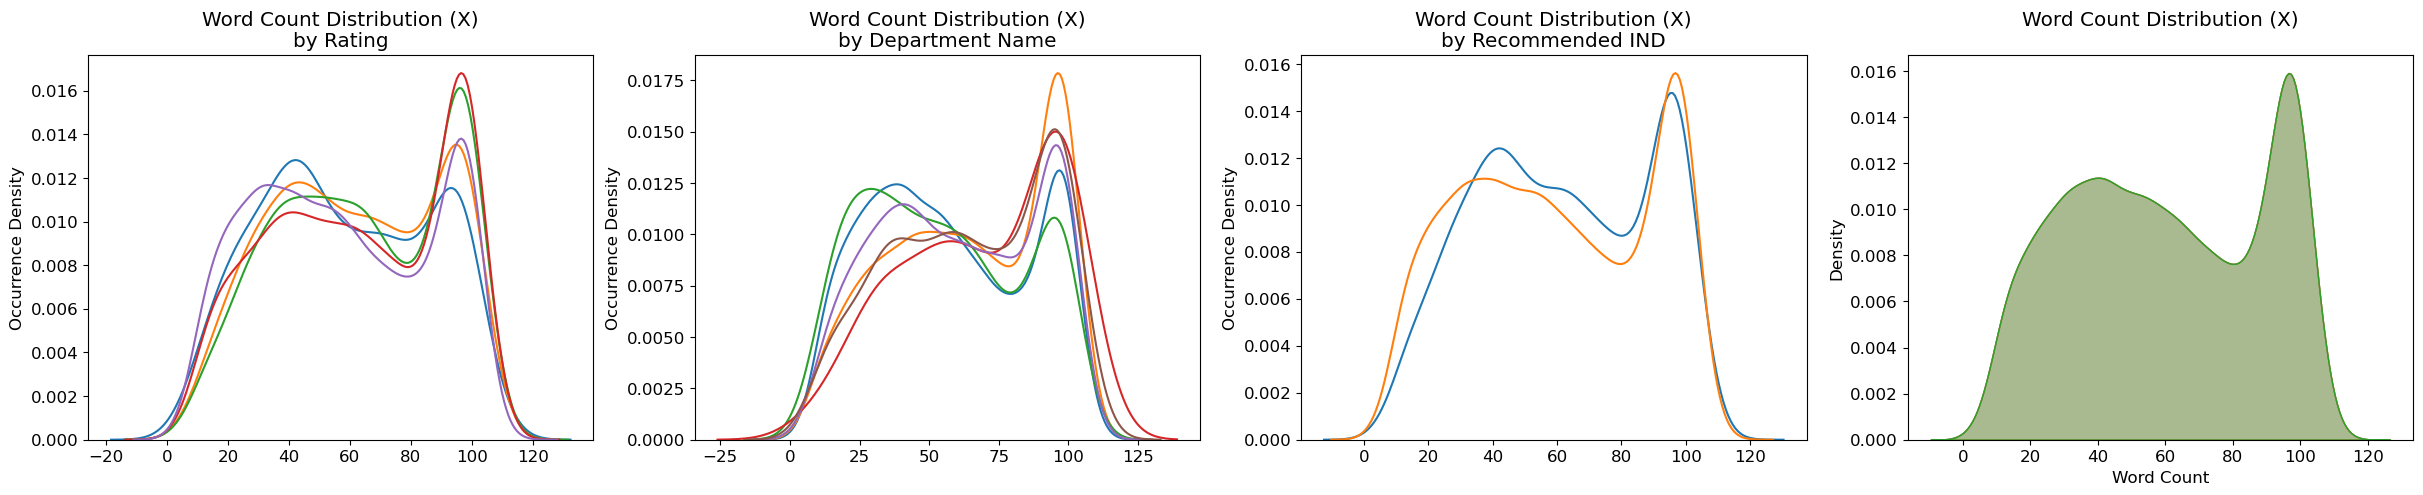


Total Word Count is: 1362476


count    22628.000000
mean        60.211950
std         28.533053
min          2.000000
25%         36.000000
50%         59.000000
75%         88.000000
max        115.000000
Name: Word Count, dtype: float64

In [17]:
f, axes = plt.subplots(1, 4, figsize=(30, 5), sharex=False)

for index, y in enumerate(['Rating', 'Department Name', 'Recommended IND']):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(df['Word Count'][df[y]==x], label=x, fill=False, ax=axes[index])
        axes[index].set_title('{} Distribution (X)\nby {}'.format('Word Count', y))
    axes[index].set_ylabel('Occurrence Density')
    axes[index].set_xlabel('')
    
    # Plot 4
    axes[3].set_title('Word Count Distribution (X)\n')
    sns.kdeplot(df['Word Count'],fill=True,ax=axes[3])
    axes[index].set_xlabel("")
    #axes[3].legend_.remove()
plt.savefig('wordcountdist-rating-deptname-recommended.png', format='png', dpi=300)
plt.show()

print("\nTotal Word Count is: {}".format(df["Word Count"].sum()))
df['Word Count'].describe().T

# Multivariate Distributions

## Categorical Variable by Categorical Variable

## Division Name by Department Name

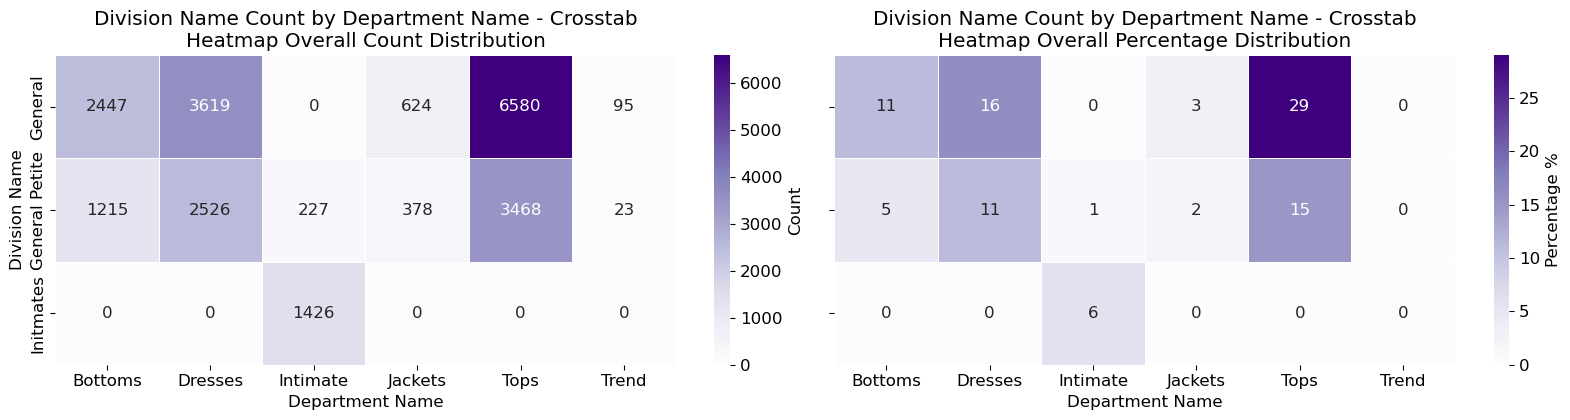

In [18]:
f, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name']),
            annot=True, linewidths=.5, ax=ax[0], fmt='g', cmap='Purples',
            cbar_kws={'label': 'Count'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name'], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap='Purples',
            cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('divname-deptname.png', format='png', dpi=300)
plt.show()

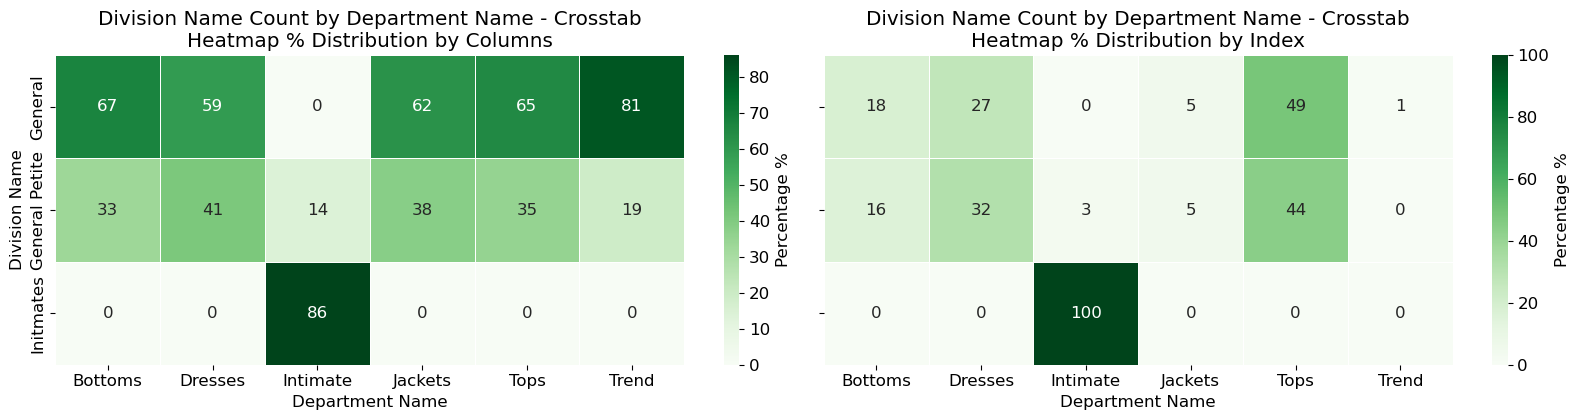

In [19]:
f, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name'], normalize='columns').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[0], fmt='g', cmap='Greens',
            cbar_kws={'label': 'Percentage %'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Columns')

sns.heatmap(pd.crosstab(df['Division Name'], df['Department Name'], normalize='index').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap='Greens',
            cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Index')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('divname-deptname-pivot.png', format='png', dpi=300)
plt.show()

## Class Name by Department Name

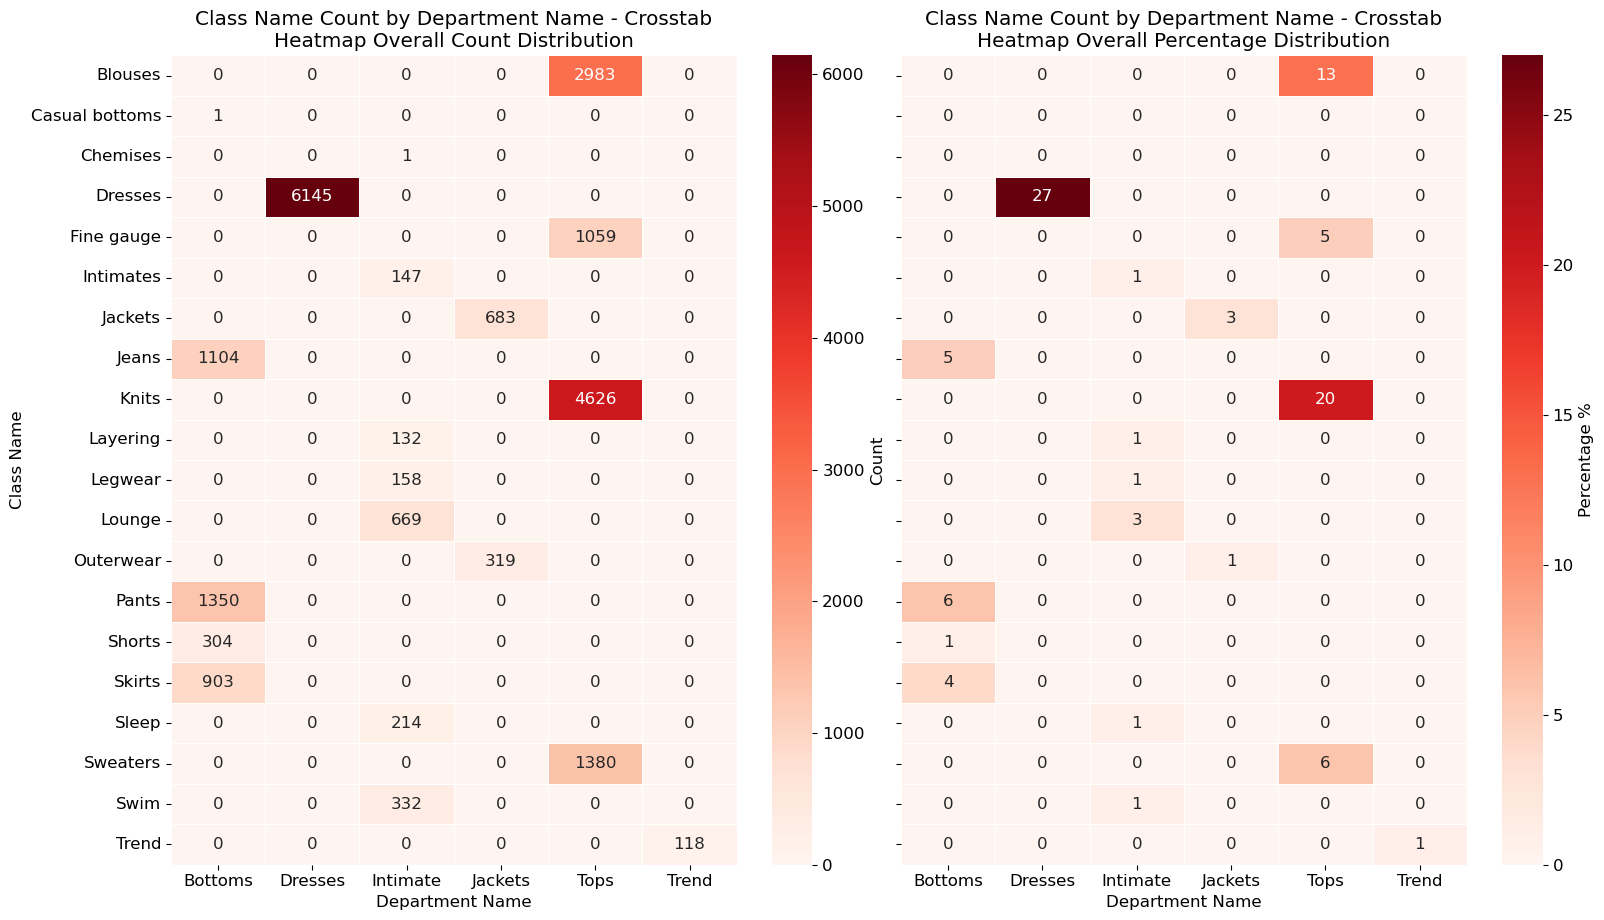

In [20]:
f, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df['Department Name']),
            annot=True, linewidths=.5, ax=ax[0], fmt='g', cmap='Reds',
            cbar_kws={'label': 'Count'})
ax[0].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Class Name'], df['Department Name'], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap='Reds',
            cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('classname-deptname.png', format='png', dpi=300)
plt.show()

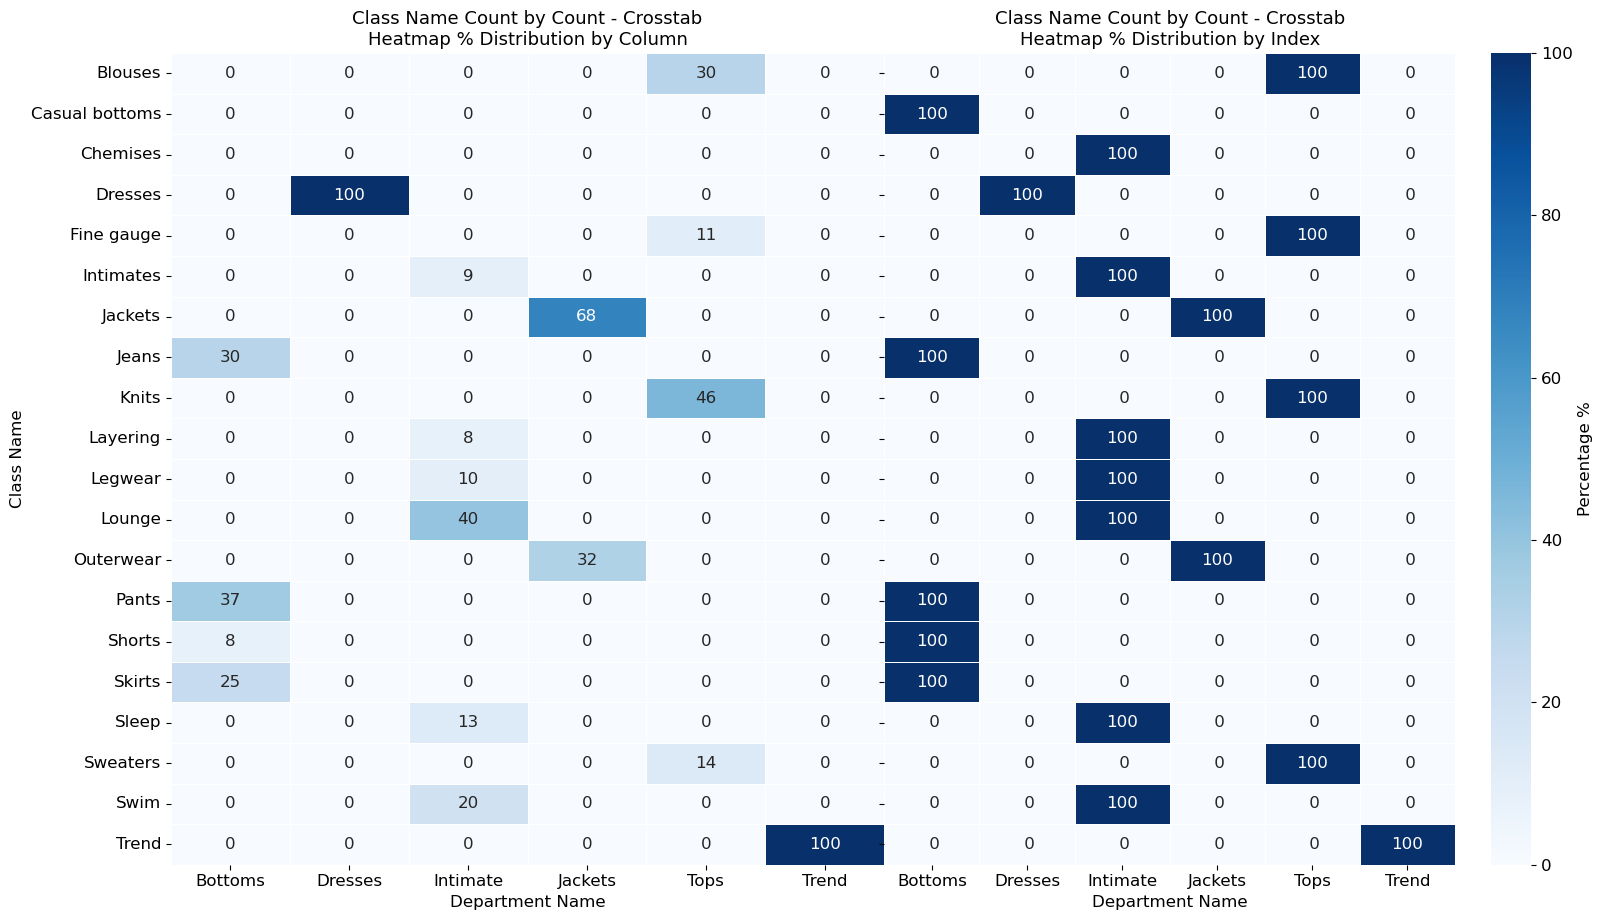

In [21]:
f, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df['Department Name'], normalize = 'columns').mul(100).round(0),
            annot=True, fmt='g', linewidths=.5, ax=ax[0],cbar=False, cmap='Blues')
ax[0].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Column', fontsize=fsize)
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df['Department Name'], normalize = 'index').mul(100).round(0),
                    annot=True, fmt='2g', linewidths=.5, ax=ax[1],cmap='Blues',
                    cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Index', fontsize=fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('classname-deptname-pivot.png', format='png', dpi=300)
plt.show()

## Division Name by Department Name

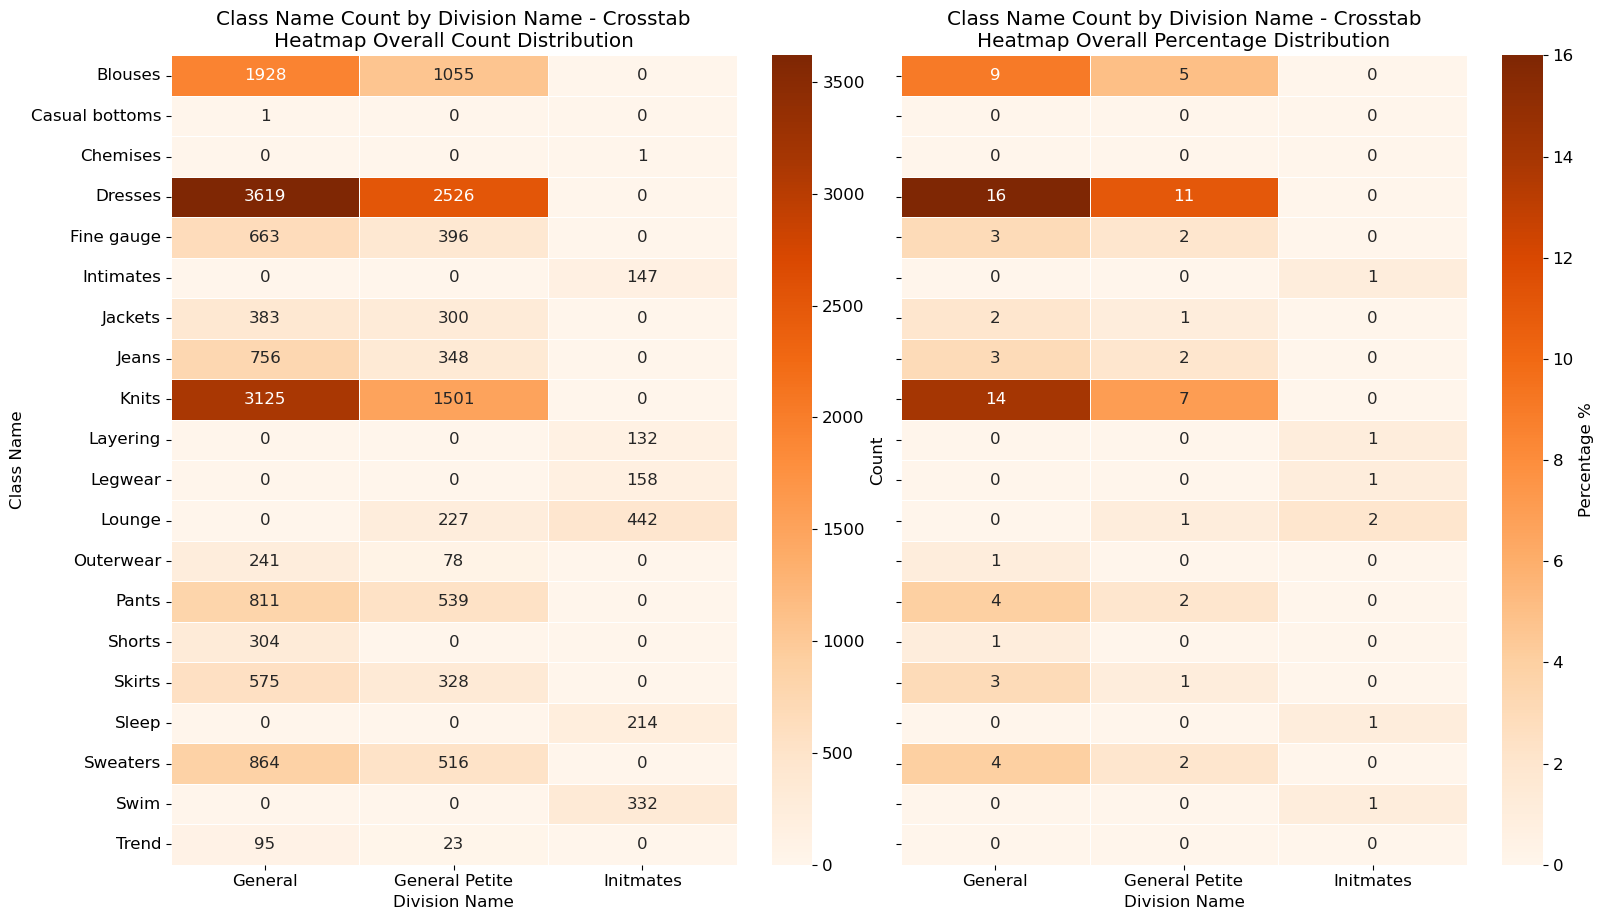

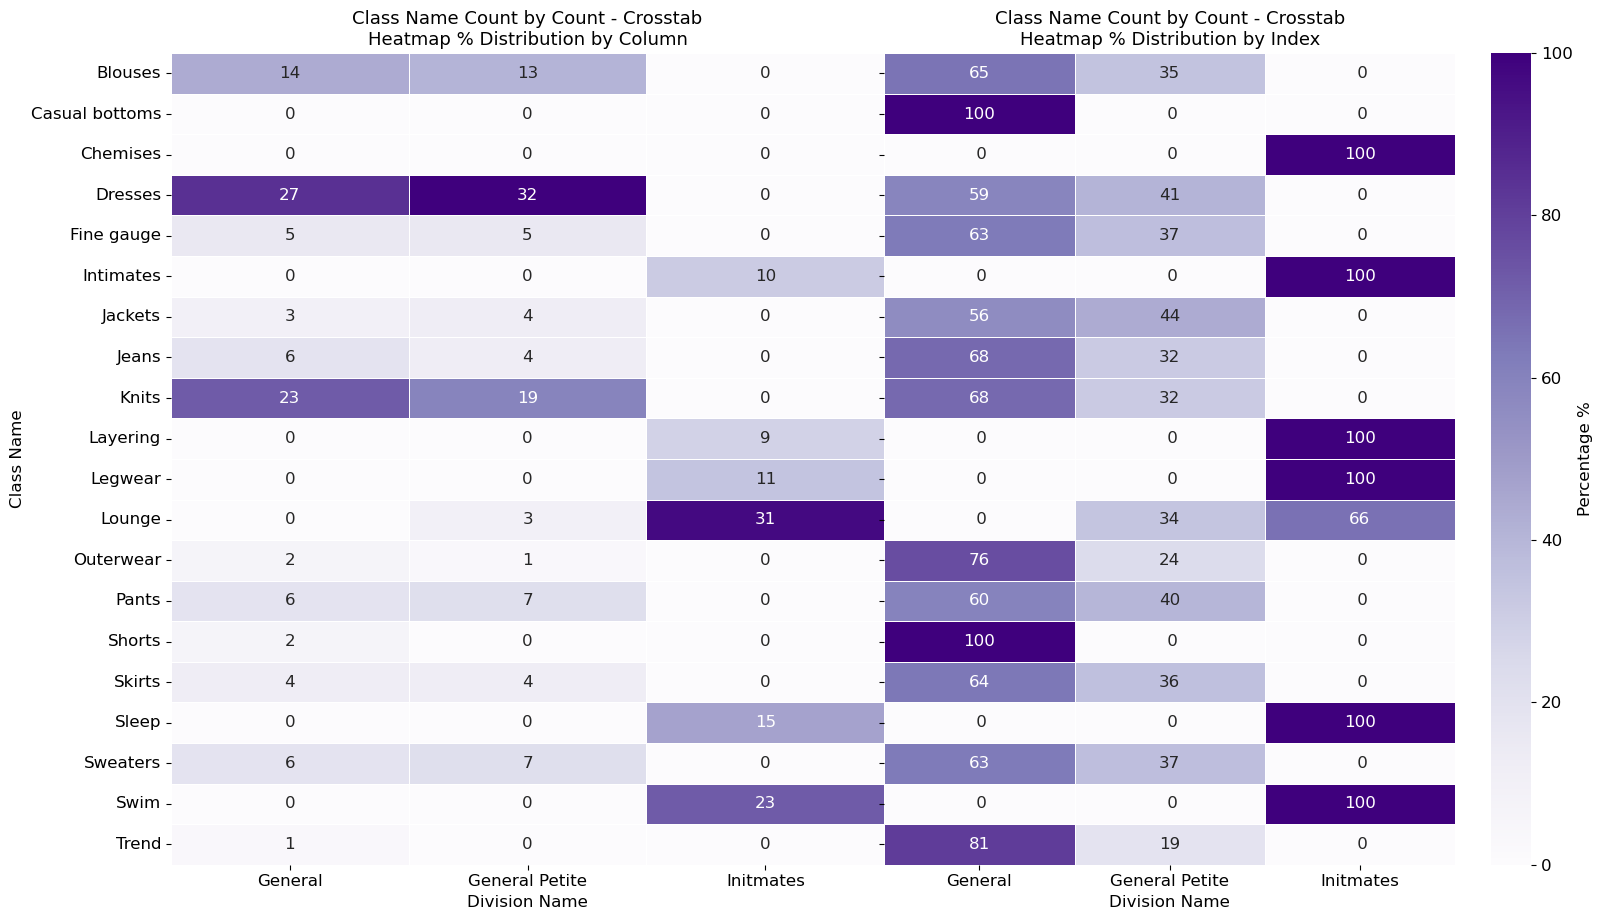

In [22]:
f, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df['Division Name']),
            annot=True, linewidths=.5, ax=ax[0], fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Count'})
ax[0].set_title('Class Name Count by Division Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Class Name'], df['Division Name'], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1], fmt='g', cmap='Oranges',
            cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Division Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('classname-divname.png', format='png', dpi=300)
plt.show()

# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df['Division Name'], normalize = 'columns').mul(100).round(0),
            annot=True, fmt='g', linewidths=.5, ax=ax[0],cbar=False,cmap='Purples')
ax[0].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Column', fontsize = fsize)
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df['Division Name'], normalize = 'index').mul(100).round(0),
                    annot=True, fmt='2g', linewidths=.5, ax=ax[1], cmap='Purples',
                    cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Index', fontsize=fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.savefig('classname-divname-pivot.png', format='png', dpi=300)

## Continuous Variable by Continuous Variable

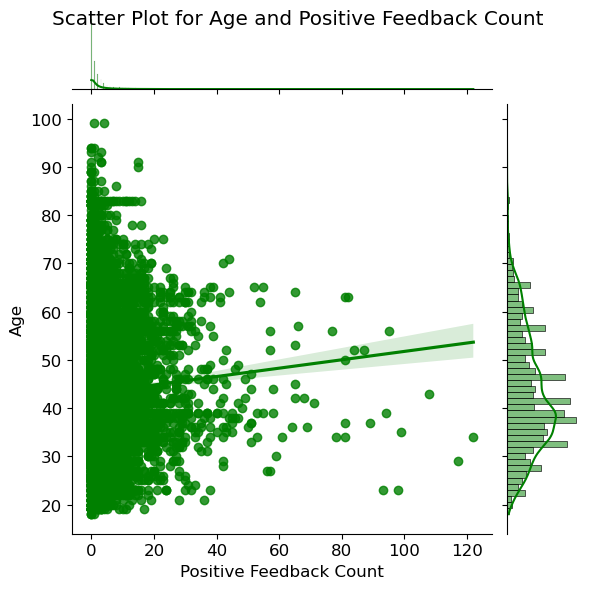

In [23]:
def minmaxscaler(df):
    return (df - df.min()) / (df.max() - df.min())

def zscorenomalize(df):
    return (df - df.mean()) / df.std()

g = sns.jointplot(x=df['Positive Feedback Count'], y=df['Age'], kind='reg', color='g')
g.fig.suptitle("Scatter Plot for Age and Positive Feedback Count")
plt.savefig('positivefeedback-age.png', format='png', dpi=300)
plt.show()

<AxesSubplot: >

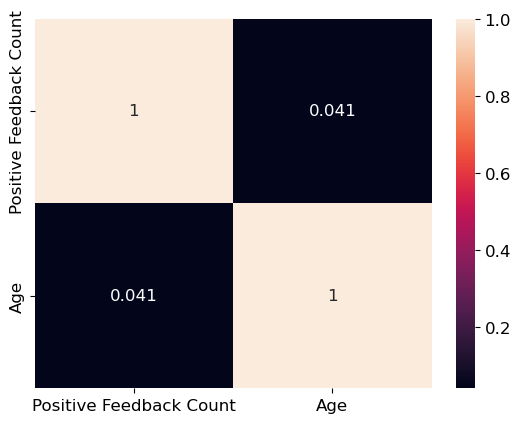

In [24]:
sns.heatmap(df[['Positive Feedback Count', 'Age']].corr(), annot=True)

## Percentage Standardize Distribution Plots

In [25]:
def percentstandardize_barplot(x, y, hue, data, ax=None, order=None):
    """
    Standardize by percentage the data using pandas functions, then plot using Seaborn.
    Function arguments are and extention of Seaborns'.
    """
    sns.barplot(x=x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
          .reset_index(drop=True)
          .groupby([x])[hue]
          .value_counts(normalize=True)
          .rename('Percentage').mul(100)
          .reset_index()
          .sort_values(hue)))
    plt.title('Percentage Frequency of {} by {}'.format(hue, x))
    plt.ylabel('Percentage %')

## Recommended IND by Department and Division

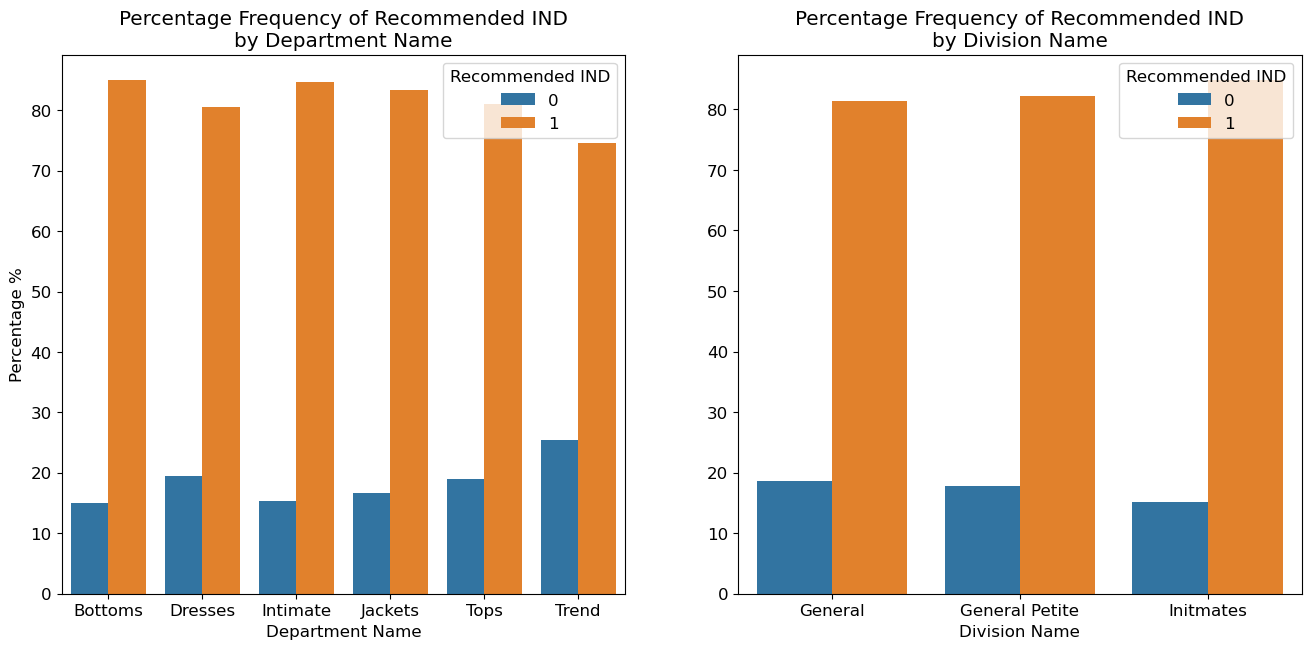

In [26]:
huevar = 'Recommended IND'
f, axes = plt.subplots(1, 2, figsize=(16, 7))
percentstandardize_barplot(x='Department Name', y='Percentage', hue=huevar,data=df, ax=axes[0])
axes[0].set_title('Percentage Frequency of {}\nby Department Name'.format(huevar))
axes[0].set_ylabel('Percentage %')
percentstandardize_barplot(x='Division Name', y='Percentage', hue=huevar, data=df, ax=axes[1])
axes[1].set_title('Percentage Frequency of {}\nby Division Name'.format(huevar))
axes[1].set_ylabel('')
plt.savefig('recommended-deptname-divname.png', format='png', dpi=300)
plt.show()

## Rating by Department and Division Name

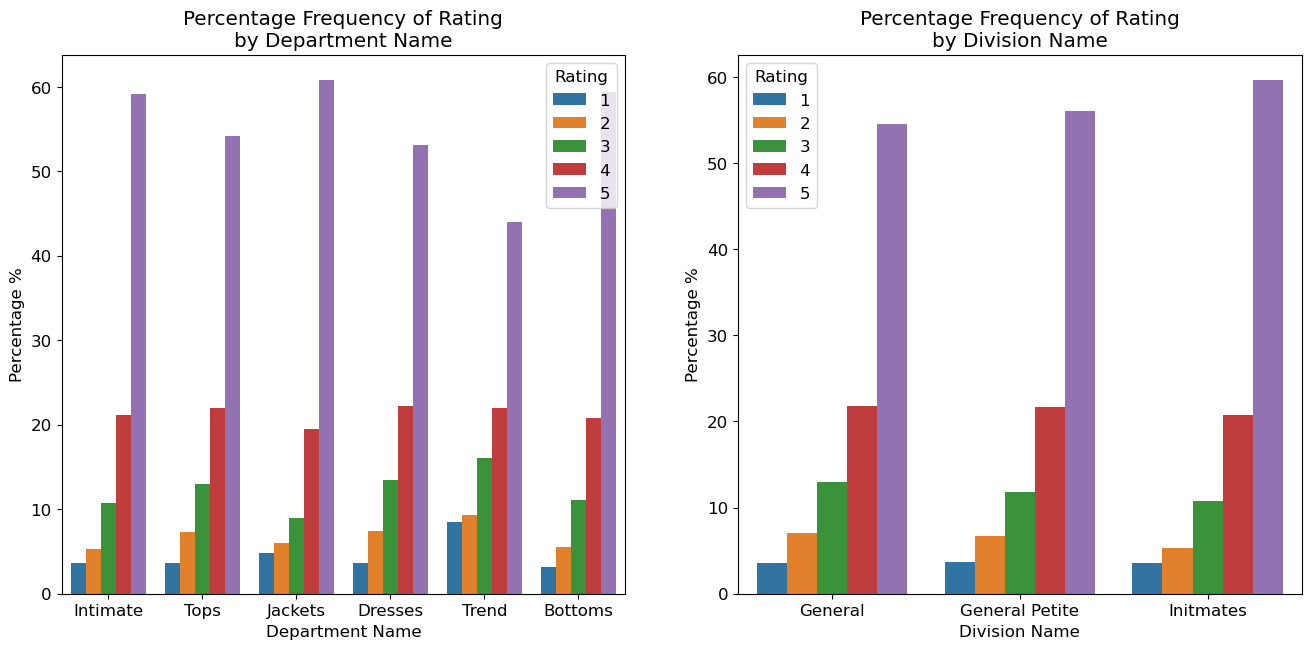

In [27]:
xvar = ['Department Name', 'Division Name']
huevar = 'Rating'
f, axes = plt.subplots(1, 2, figsize=(16, 7))
percentstandardize_barplot(x=xvar[0], y='Percentage', hue=huevar, data=df, ax=axes[0])
axes[0].set_title('Percentage Frequency of {}\nby {}'.format(huevar, xvar[0]))
axes[0].set_ylabel('Percentage %')
percentstandardize_barplot(x=xvar[1], y='Percentage', hue=huevar, data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby {}".format(huevar, xvar[1]))
plt.savefig('rating-deptname-divname.png', format='png', dpi=300)
plt.show()

## Rating by Recommended IND

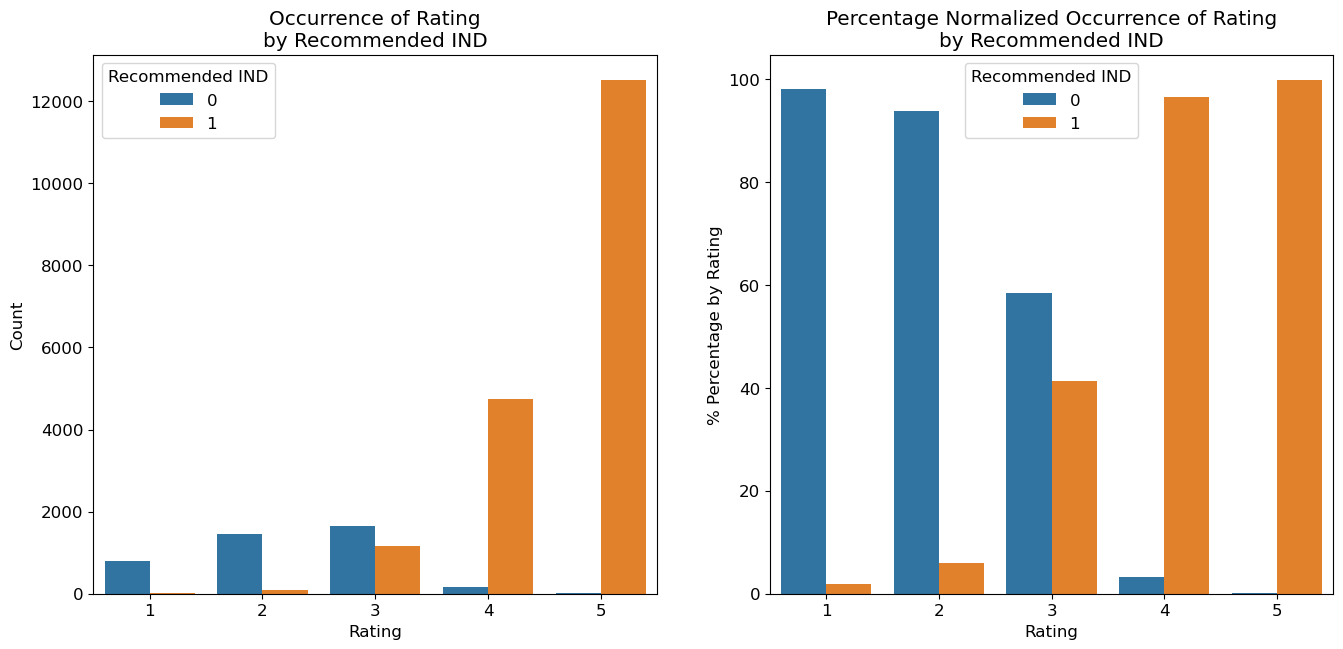

In [28]:
huevar = 'Rating'
f, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.countplot(x='Rating', hue='Recommended IND', data=df, ax=axes[0])
axes[0].set_title('Occurrence of {}\nby {}'.format(huevar, 'Recommended IND'))
axes[0].set_ylabel('Count')
percentstandardize_barplot(x='Rating', y='Percentage', hue='Recommended IND', data=df, ax=axes[1])
axes[1].set_title('Percentage Normalized Occurrence of {}\nby {}'.format(huevar, 'Recommended IND'))
axes[1].set_ylabel('% Percentage by Rating')
plt.savefig('rating-recommended.png', format='png', dpi=300)
plt.show()

# Multivariate Analysis and Descriptive Statistics

## Rating by Recommended IND

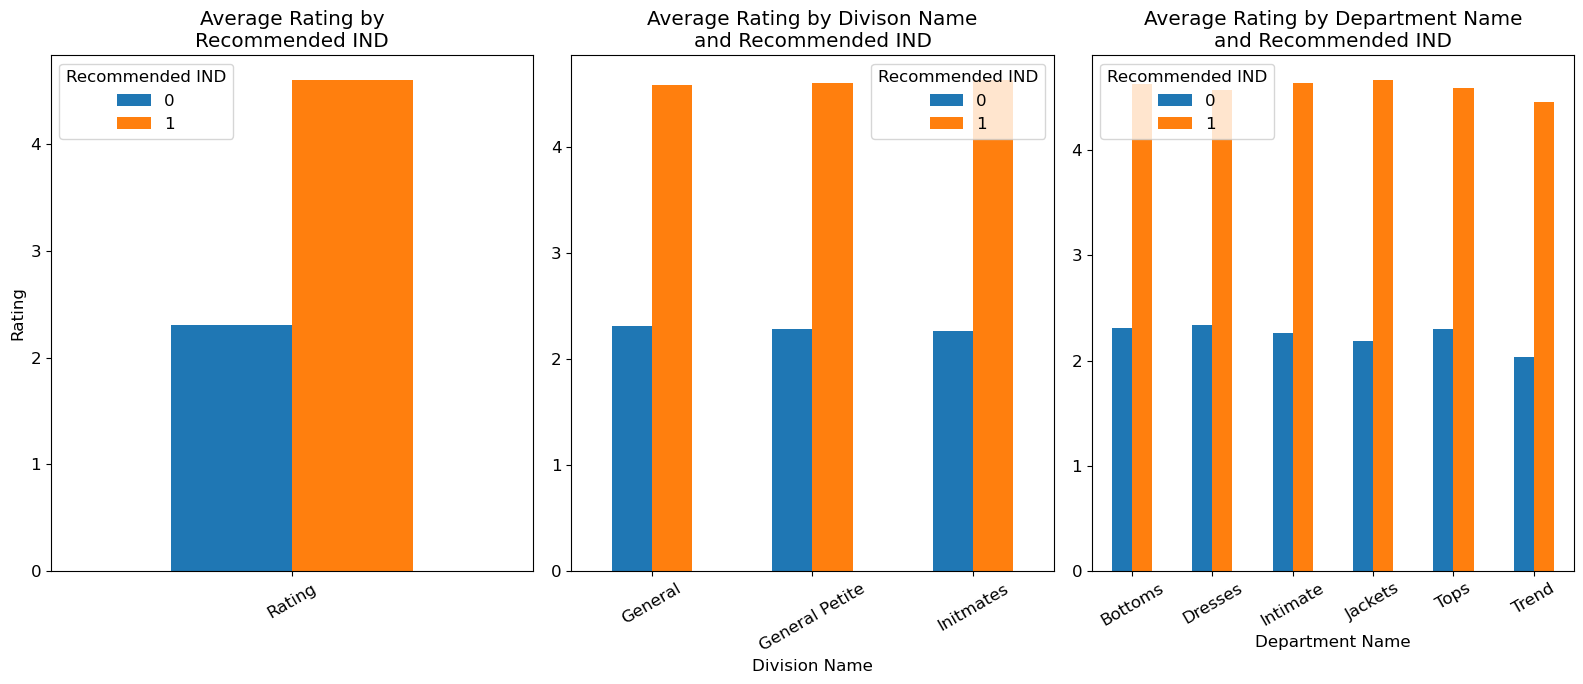

In [29]:
f, axes = plt.subplots(1, 3, figsize=(16, 7))
rot = 30
df.pivot_table('Rating',
               columns=['Recommended IND']).plot.bar(ax=axes[0], rot=rot)
axes[0].set_title('Average Rating by\nRecommended IND')
df.pivot_table('Rating', index='Division Name',
               columns=['Recommended IND']).plot.bar(ax=axes[1], rot=rot)
axes[1].set_title('Average Rating by Divison Name\nand Recommended IND')
df.pivot_table('Rating', index='Department Name',
               columns=['Recommended IND']).plot.bar(ax=axes[2], rot=rot)
axes[0].set_ylabel('Rating')
axes[2].set_title('Average Rating by Department Name\nand Recommended IND')
f.tight_layout()
plt.savefig('meanrating-deptname-recommended.png', format='png', dpi=300)
plt.show()

## Average Rating and Recommended IND by Clothing ID Correlation

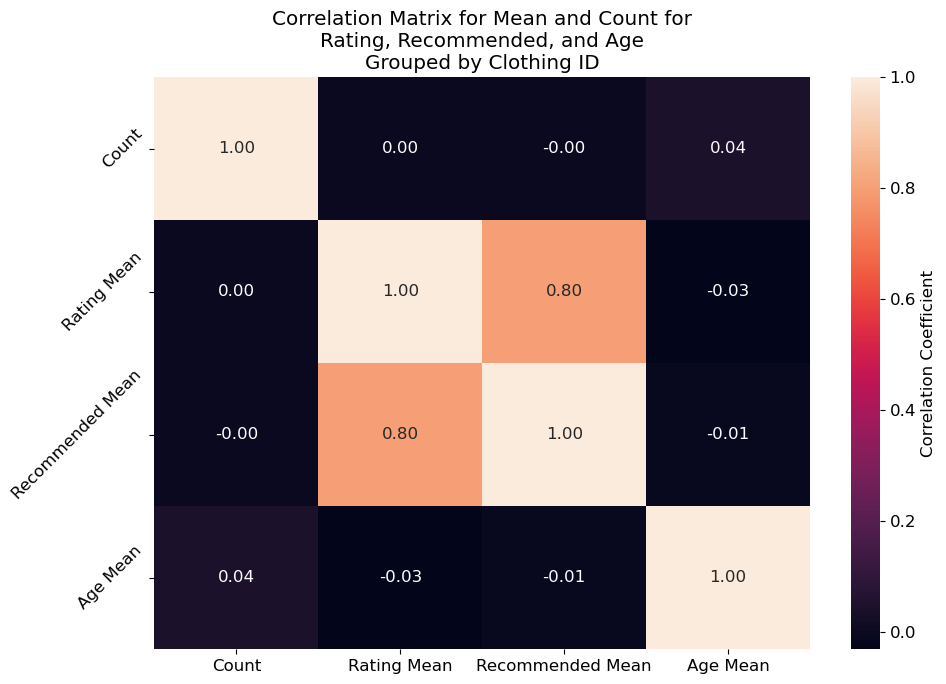

In [30]:
temp = (df.groupby('Clothing ID')[['Rating', 'Recommended IND', 'Age']]
        .aggregate(['count', 'mean']))
temp.columns = ['Count', 'Rating Mean', 'Recommended IND Count',
                'Recommended Mean', 'Age Count', 'Age Mean']
temp.drop(['Recommended IND Count', 'Age Count'], axis=1, inplace=True)

# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[10, 7])
ax = sns.heatmap(temp.corr(),
                 annot=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Correlation Matrix for Mean and Count for\nRating, Recommended, and Age\nGrouped by Clothing ID')
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig('meanrating-recommended-clothing-corr.png', format='png', dpi=300)
plt.show()

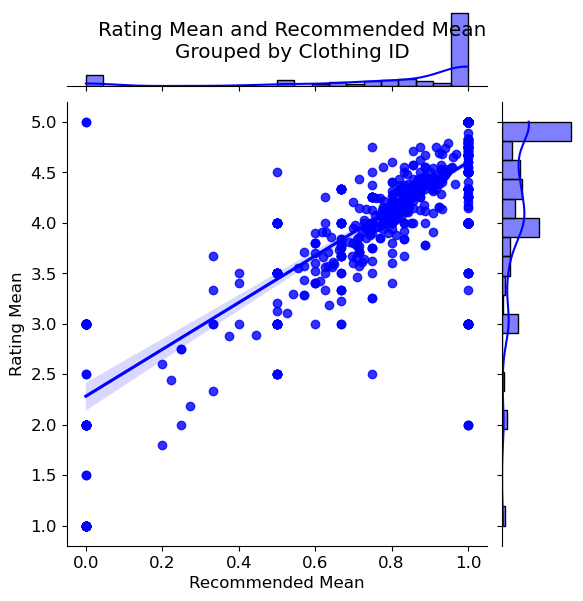

In [31]:
g = sns.jointplot(x='Recommended Mean', y='Rating Mean', data=temp,
                  kind='reg', color='b')
plt.subplots_adjust(top=0.999)
g.fig.suptitle('Rating Mean and Recommended Mean\nGrouped by Clothing ID')
plt.savefig('meanrating-recommended-clothing.png', format='png', dpi=300)
plt.show()

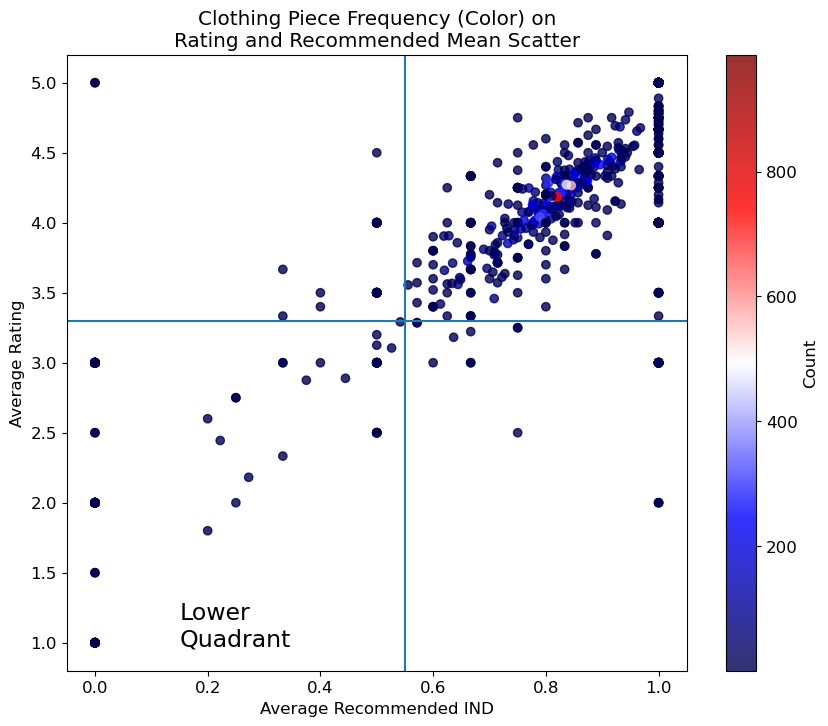

Count  Rating Mean  Recommended Mean    Age Mean
count  204.000000   204.000000        204.000000  204.000000
mean     2.308824     2.763338          0.316315   41.883954
std      2.798261     0.819220          0.351723   10.858979
min      1.000000     1.000000          0.000000   20.000000
25%      1.000000     2.136364          0.000000   34.687500
50%      1.000000     3.000000          0.250000   41.142857
75%      2.000000     3.000000          0.500000   47.000000
max     24.000000     5.000000          1.000000   74.000000

In [32]:
plt.figure(figsize=(10, 8))
plt.scatter(temp['Recommended Mean'], temp['Rating Mean'],
            alpha=.8, c=temp["Count"], cmap='seismic')
cbar = plt.colorbar() # Color bar. Vive la France!
cbar.set_label('Count', rotation=90)
plt.xlabel('Average Recommended IND')
plt.ylabel('Average Rating')
plt.title('Clothing Piece Frequency (Color) on\nRating and Recommended Mean Scatter')

# Vertical and Horizontal Lines
l = plt.axhline(y=3.3)
l = plt.axvline(x=.55)

# Text
plt.text(.15, 1, 'Lower\nQuadrant', ha='left', wrap=True, fontsize=17)
plt.savefig('low-quadrant.png', format='png', dpi=300)
plt.show()

# Descriptives for LOW QUADRANT
temp[(temp['Rating Mean'] < 3.3) | (temp['Recommended Mean'] <= .55)].describe()


## Average Rating and Recommended IND by Class Name Correlation

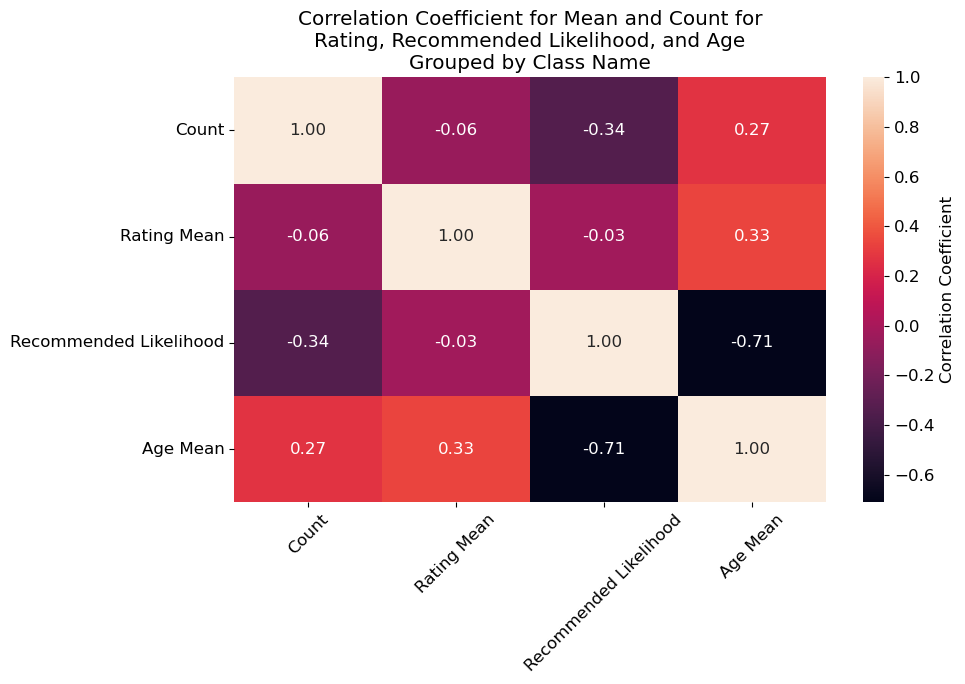

Class Categories:
 ['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' 'Chemises']


In [33]:
key = 'Class Name'
temp = (df.groupby(key)[['Rating', 'Recommended IND', 'Age']]
        .aggregate(['count', 'mean']))
temp.columns = ['Count', 'Rating Mean', 'Recommended Likelihood Count',
                'Recommended Likelihood', 'Age Count', 'Age Mean']
temp.drop(['Recommended Likelihood Count', 'Age Count'], axis=1, inplace=True)

# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[10, 7])
ax = sns.heatmap(temp.corr(),
                 annot=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Correlation Coefficient for Mean and Count for\nRating, Recommended Likelihood, and Age\nGrouped by {}'.format(key))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('meanrating-recommended-classname-corr.png', format='png', dpi=300)
plt.show()
print('Class Categories:\n',df['Class Name'].unique())

(0.7, 1.01)

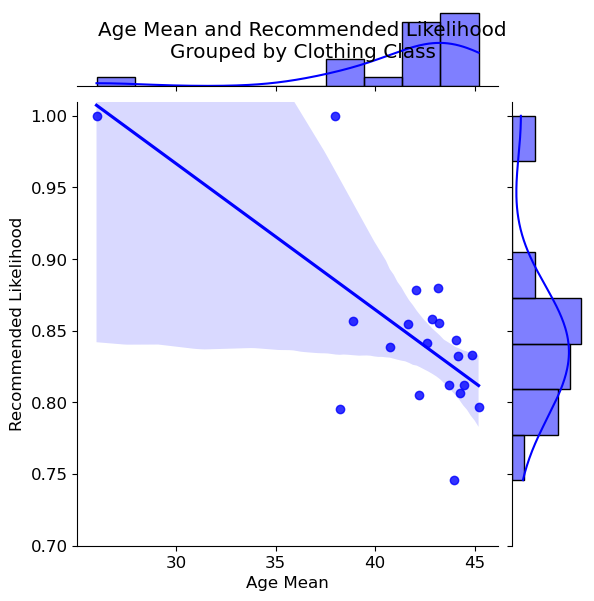

In [34]:
g = sns.jointplot(y='Recommended Likelihood', x='Age Mean', data=temp,
                  kind='reg', color='b')
plt.subplots_adjust(top=0.999)
g.fig.suptitle('Age Mean and Recommended Likelihood\nGrouped by Clothing Class')
plt.savefig('meanage-recommended-clothing.png', format='png', dpi=300)
plt.ylim(.7, 1.01)

# Working with Text

In [35]:
pd.set_option('max_colwidth', 500)
df[["Title","Review Text", "Rating"]].sample(7)

Title  \
9662             Love it!   
4199   Goes with anything   
3416                  NaN   
11162  Great summer skirt   
19841                 NaN   
14259  Unfortunate design   
10902       Underwhelming   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Review Text  \
9662                                                                                                                                                                                                                                                                                 I had been looking for a new plaid shirt for fall. this one is perfect! the yellow is muted, but i really like it that way. other reviewers have commented on poor quality, but it doesn't seem that bad to me. definitely recommend!   
4199                                  This shirt is a simple but versatile top. it goes anywhere with anything so it's a great travel piece. i'm curvy on top but short waisted and this shirt does a good job of disguising that figure flaw. i got loads of compliments from men who liked the femininity that stops short of 'sugary' as one guy put it. it's quite comfortable and doesn't bunch up when one sits down. i wore it with copper jewelry and that really made it 'pop.' a great piece for one's wardrobe.   
3416                                                                                                                                                                                                                                                                                                                                                                                                                                  The petites fit perfect!!  these are so comfortable, i will get much us out of them!   
11162  This is a really cute skirt, and it seems well-made (good stitch-work and enough weight to the fabric that i'm not worried about underwear show-through but not too heavy for a summer skirt). i sized up from an 8 to a 10 because it was difficult to get the skirt over my bum. also, the zipper doesn't lay flat when i have it in the back of the skirt so i just shifted it to the side--still looks great imo. i think if you have hips or a booty you might want to size up on this skirt. color is true to   
19841                                                                                                                                                                                                                                                                                                                                                                                                Beautiful top for summer. love the yellow under the thin white fabric. the photo is good representation. running big.   
14259                                                                                                                                                                                                                                                                                    Construction excellent. the dress was pretty big around the hip...does not have a shape like seen in the picture. the fabric was beautiful but was stiff...like furniture. the color was not as vibrant as the picture. returned.   
10902                                                                                                                                                                                                                    

## Text Cleaning

In [36]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words] #4
    return words

## Sentiment Analysis

In [37]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Pre-Processing
SIA = SentimentIntensityAnalyzer()
df['Review Text']= df['Review Text'].astype(str)

# Applying Model, Variable Creation
df['Polarity Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['compound'])
df['Neutral Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neu'])
df['Negative Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['neg'])
df['Positive Score'] = df['Review Text'].apply(lambda x: SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment'] = ''
df.loc[df['Polarity Score'] > 0, 'Sentiment'] = 'Positive'
df.loc[df['Polarity Score'] == 0, 'Sentiment'] = 'Neutral'
df.loc[df['Polarity Score'] < 0, 'Sentiment'] = 'Negative'

## Normalize Plots for Sentiment Distribution

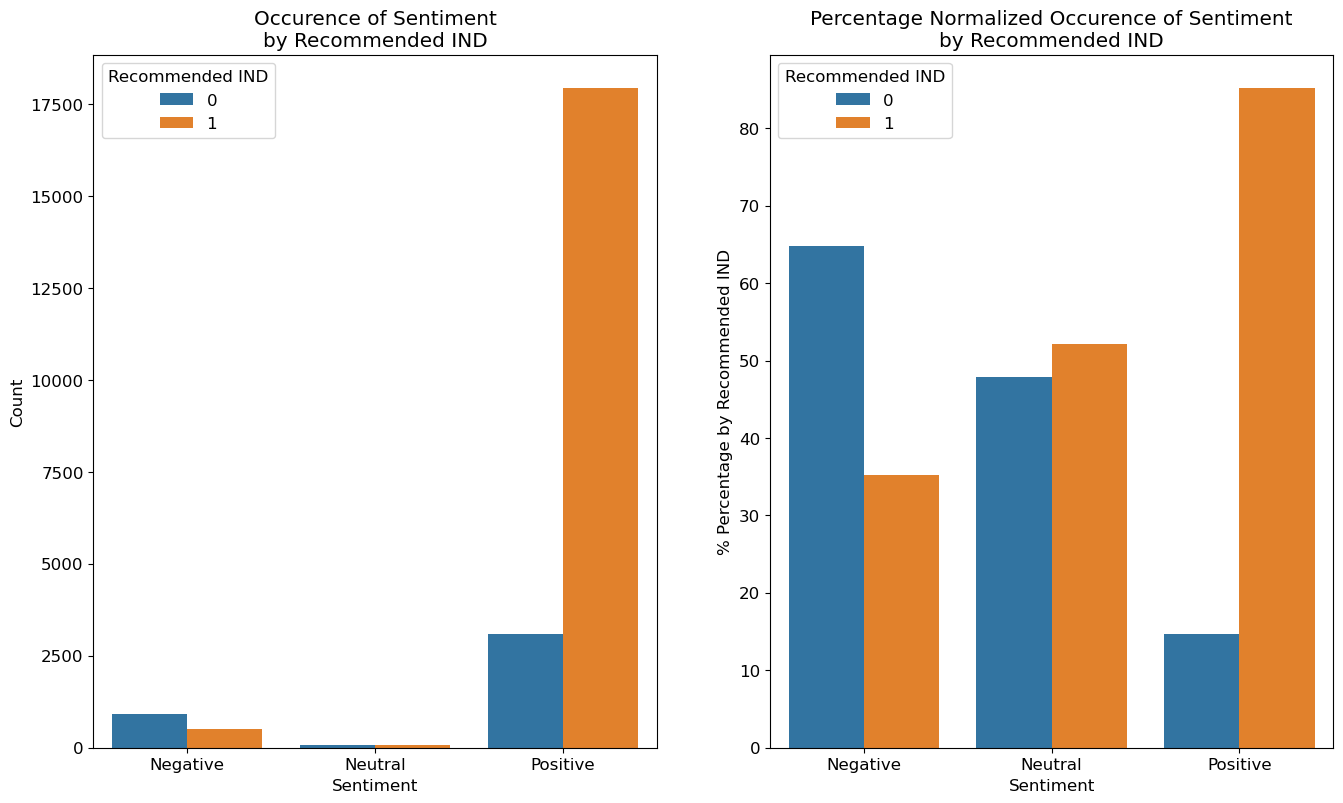

In [38]:
huevar = 'Recommended IND'
xvar = 'Sentiment'
f, axes = plt.subplots(1, 2, figsize=(16, 9))
sns.countplot(x=xvar, hue=huevar,data=df, ax=axes[0], order=['Negative', 'Neutral', 'Positive'])
axes[0].set_title('Occurence of {}\nby {}'.format(xvar, huevar))
axes[0].set_ylabel('Count')
percentstandardize_barplot(x=xvar, y='Percentage', hue=huevar, data=df, ax=axes[1])
axes[1].set_title('Percentage Normalized Occurence of {}\nby {}'.format(xvar, huevar))
axes[1].set_ylabel('% Percentage by {}'.format(huevar))
plt.savefig('norm-sentimentdist.png', format='png', dpi=300)
plt.show()

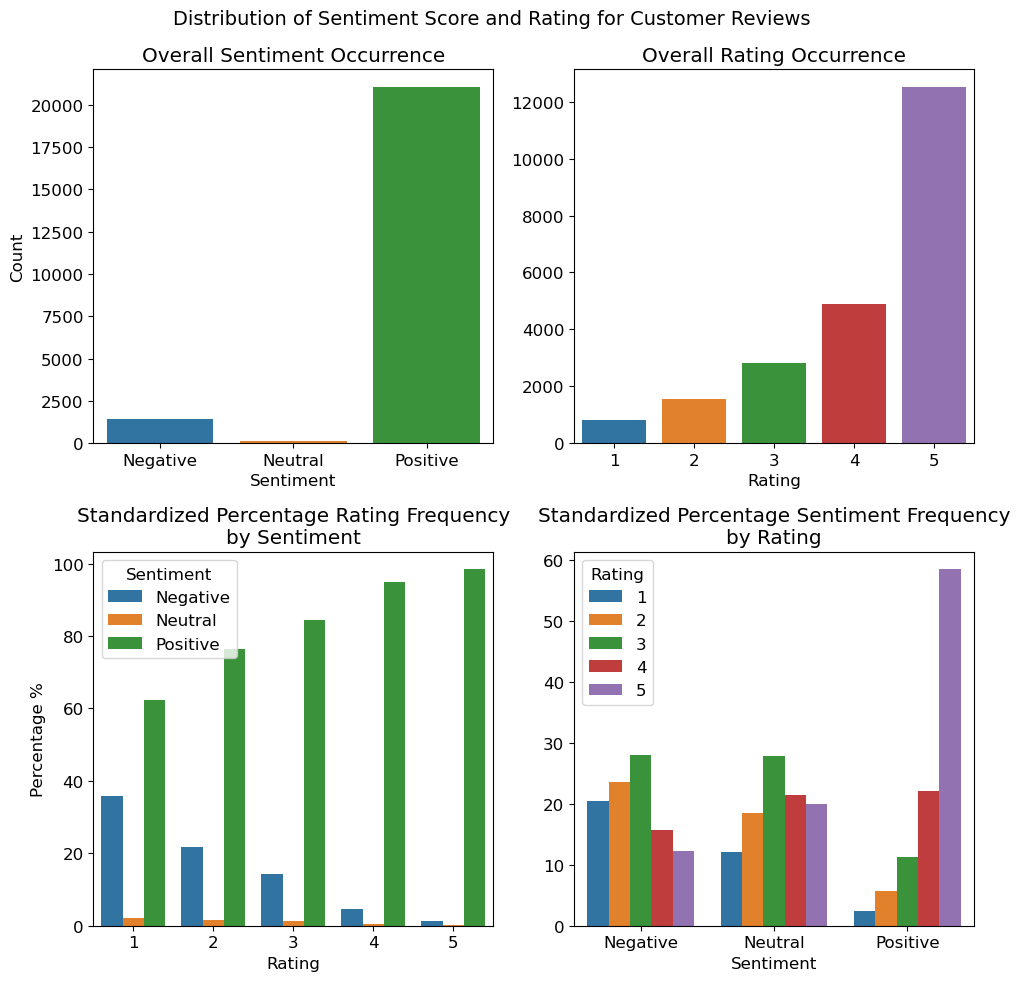

In [39]:
f, axes = plt.subplots(2, 2, figsize=[10, 10])
sns.countplot(x='Sentiment', data=df, ax=axes[0, 0], order=['Negative', 'Neutral', 'Positive'])
axes[0,0].set_xlabel('Sentiment')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Overall Sentiment Occurrence')

sns.countplot(x='Rating', data=df, ax=axes[0, 1])
axes[0,1].set_xlabel('Rating')
axes[0,1].set_ylabel('')
axes[0,1].set_title('Overall Rating Occurrence')

percentstandardize_barplot(x='Rating', y='Percentage', hue='Sentiment', data=df, ax=axes[1, 0])
axes[1,0].set_xlabel('Rating')
axes[1,0].set_ylabel('Percentage %')
axes[1,0].set_title('Standardized Percentage Rating Frequency\nby Sentiment')

percentstandardize_barplot(x='Sentiment', y='Percentage',hue='Rating', data=df, ax=axes[1, 1])
axes[1,1].set_ylabel('Occurrence Frequency')
axes[1,1].set_title('Standardized Percentage Sentiment Frequency\nby Rating')
axes[1,1].set_xlabel('Sentiment')
axes[1,1].set_ylabel('')

f.suptitle('Distribution of Sentiment Score and Rating for Customer Reviews', fontsize=14)
f.tight_layout()
f.subplots_adjust(top=0.92)
plt.savefig('sentimentscoredist-rating.png', format='png', dpi=300)
plt.show()

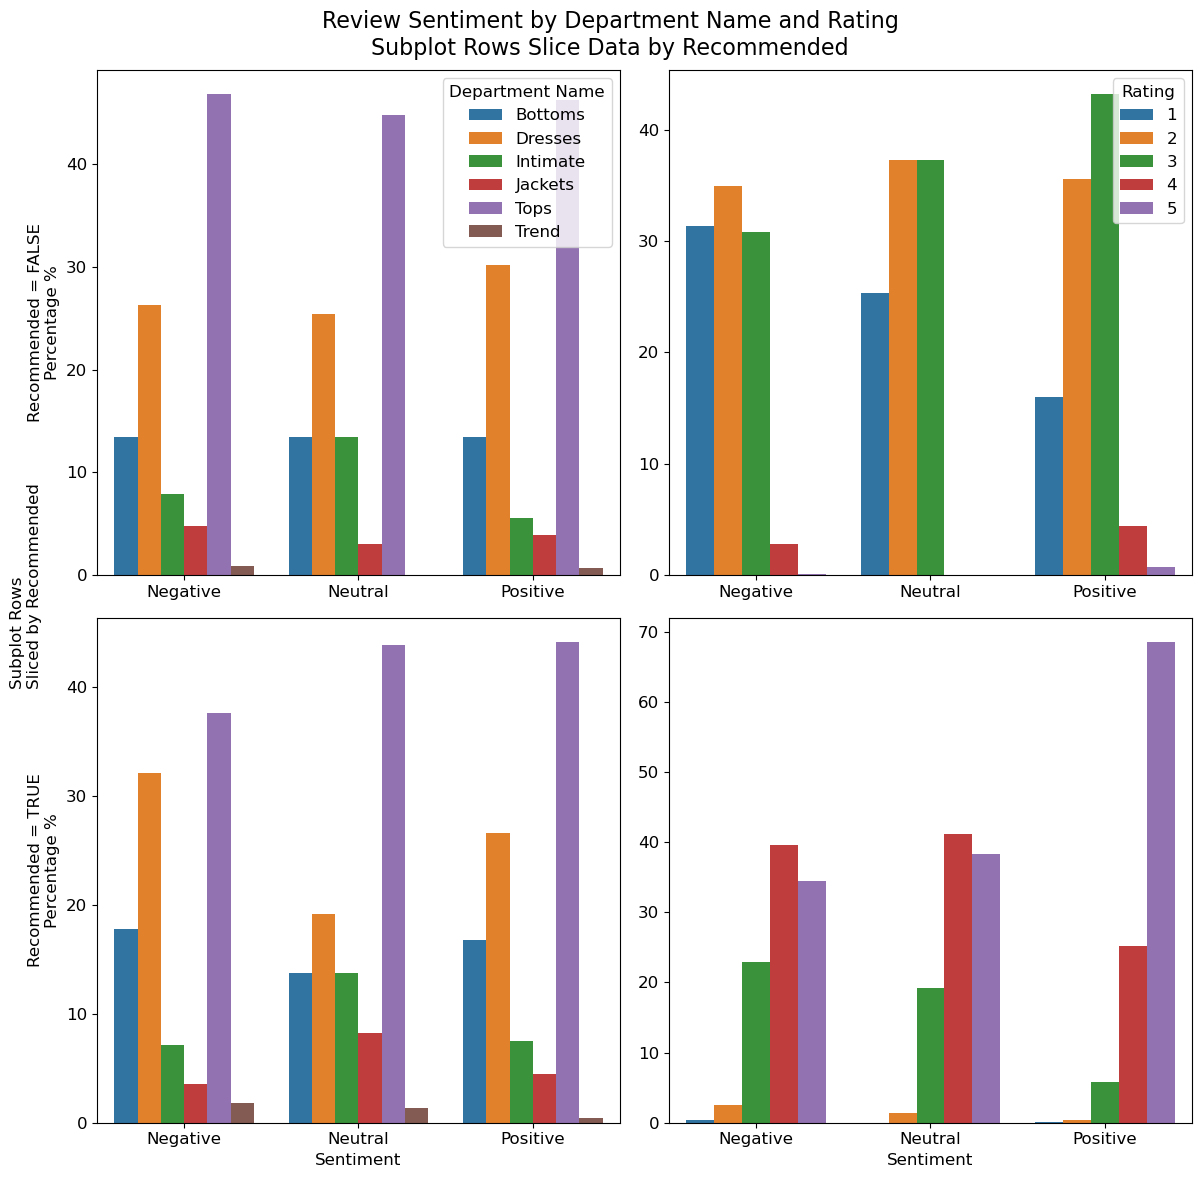

In [40]:
xvar = 'Sentiment'
huevar = 'Department Name'
rowvar = 'Recommended IND'

# Plot
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False, sharey=False)
for i,x in enumerate(set(df[rowvar][df[rowvar].notnull()])):
    percentstandardize_barplot(x=xvar, y='Percentage', hue=huevar, data=df[df[rowvar] == x],
                               ax=axes[i,0], order=['Negative','Neutral','Positive'])
    percentstandardize_barplot(x=xvar, y='Percentage', hue='Rating', data=df[df[rowvar] == x],
                               ax=axes[i,1], order=['Negative','Neutral','Positive'])

# Plot Aesthetics
axes[1,0].legend_.remove()
axes[1,1].legend_.remove()
axes[0,1].set_ylabel('')
axes[1,1].set_ylabel('')
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[0,0].set_ylabel('Recommended = FALSE\nPercentage %')
axes[1,0].set_ylabel('Recommended = TRUE\nPercentage %')
axes[1,1].set_title('')

# Common title and ylabel
f.text(0.0, 0.5, 'Subplot Rows\nSliced by Recommended', va='center', rotation='vertical', fontsize=12)
f.suptitle('Review Sentiment by Department Name and Rating\nSubplot Rows Slice Data by Recommended', fontsize=16)
f.tight_layout()
f.subplots_adjust(top=0.93)
plt.savefig('sentiment-deptname-rating-recommended.png', format='png', dpi=300)
plt.show()

C:\Users\cjcar\AppData\Local\Temp\ipykernel_11836\587760040.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df.corr(), annot=True,


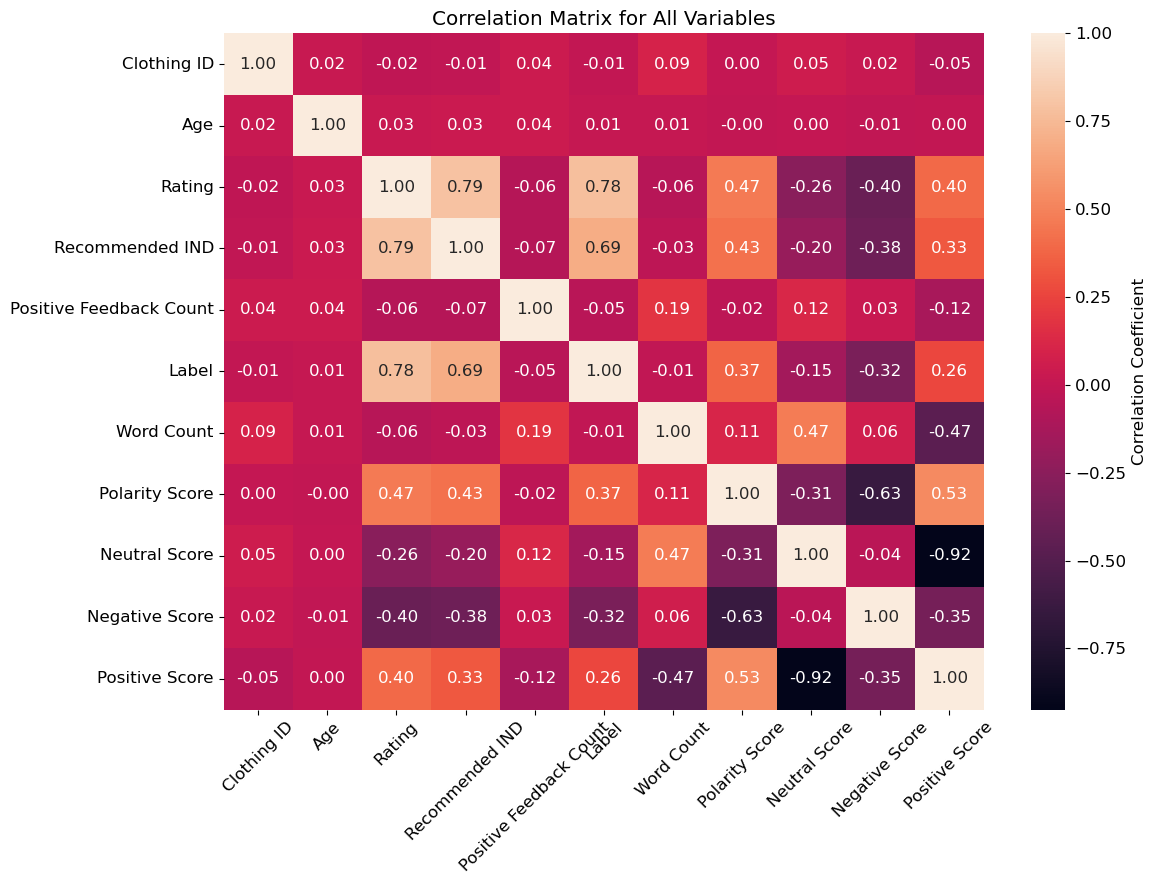

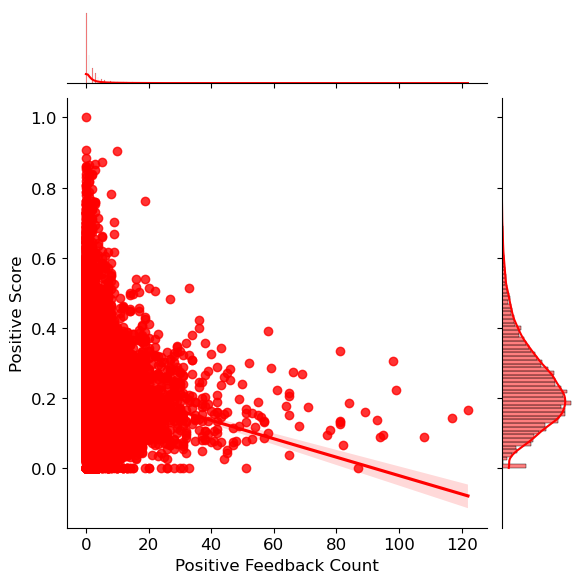

In [46]:
f, ax = plt.subplots(figsize=[12, 9])
ax = sns.heatmap(df.corr(), annot=True,
                 fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Correlation Matrix for All Variables')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('corr-all.png', format='png', dpi=300)
plt.show()

# Sentiment Positivity Score by Positive Feedback Count
ax = sns.jointplot(x= df['Positive Feedback Count'], y=df['Positive Score'], kind='reg', color='r')
plt.savefig('positivesentiment-positivefeedback.png', format='png', dpi=300)
plt.show()

# Word Distribution and Word Cloud

In [41]:
import matplotlib as mpl

stopwords = set(STOPWORDS)
size = (20, 10)

def cloud(text, title, stopwords=stopwords, size=size):
    mpl.rcParams['figure.figsize'] = (10.0, 10.0)
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['figure.subplot.bottom'] = .1
    
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords).generate(str(text))
    
    fig = plt.figure(figsize=size, facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=50, color='y')
    plt.tight_layout()
    plt.savefig('{}.png'.format(title), format='png', dpi=300)
    plt.show()
    
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    mpl.style.use('ggplot')
    rslt.plot.bar(rot=0)
    
def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rlst = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency']).set_index('Word')
    return rlst

## Visualize Titles

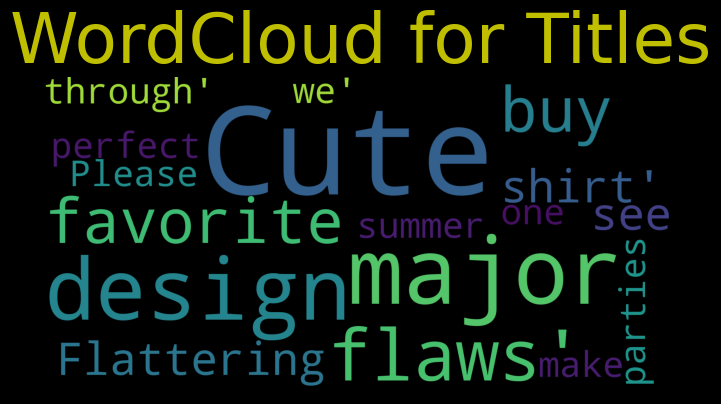

In [42]:
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df['Class Name'][df['Class Name'].notnull()].unique())]
                + ['dress', 'petite'])

# Cloud
cloud(text=df.Title[df.Title.notnull()].astype(str).values,
      title='WordCloud for Titles',
      stopwords=new_stop,
      size = (7,4))

## Visualize Reviews

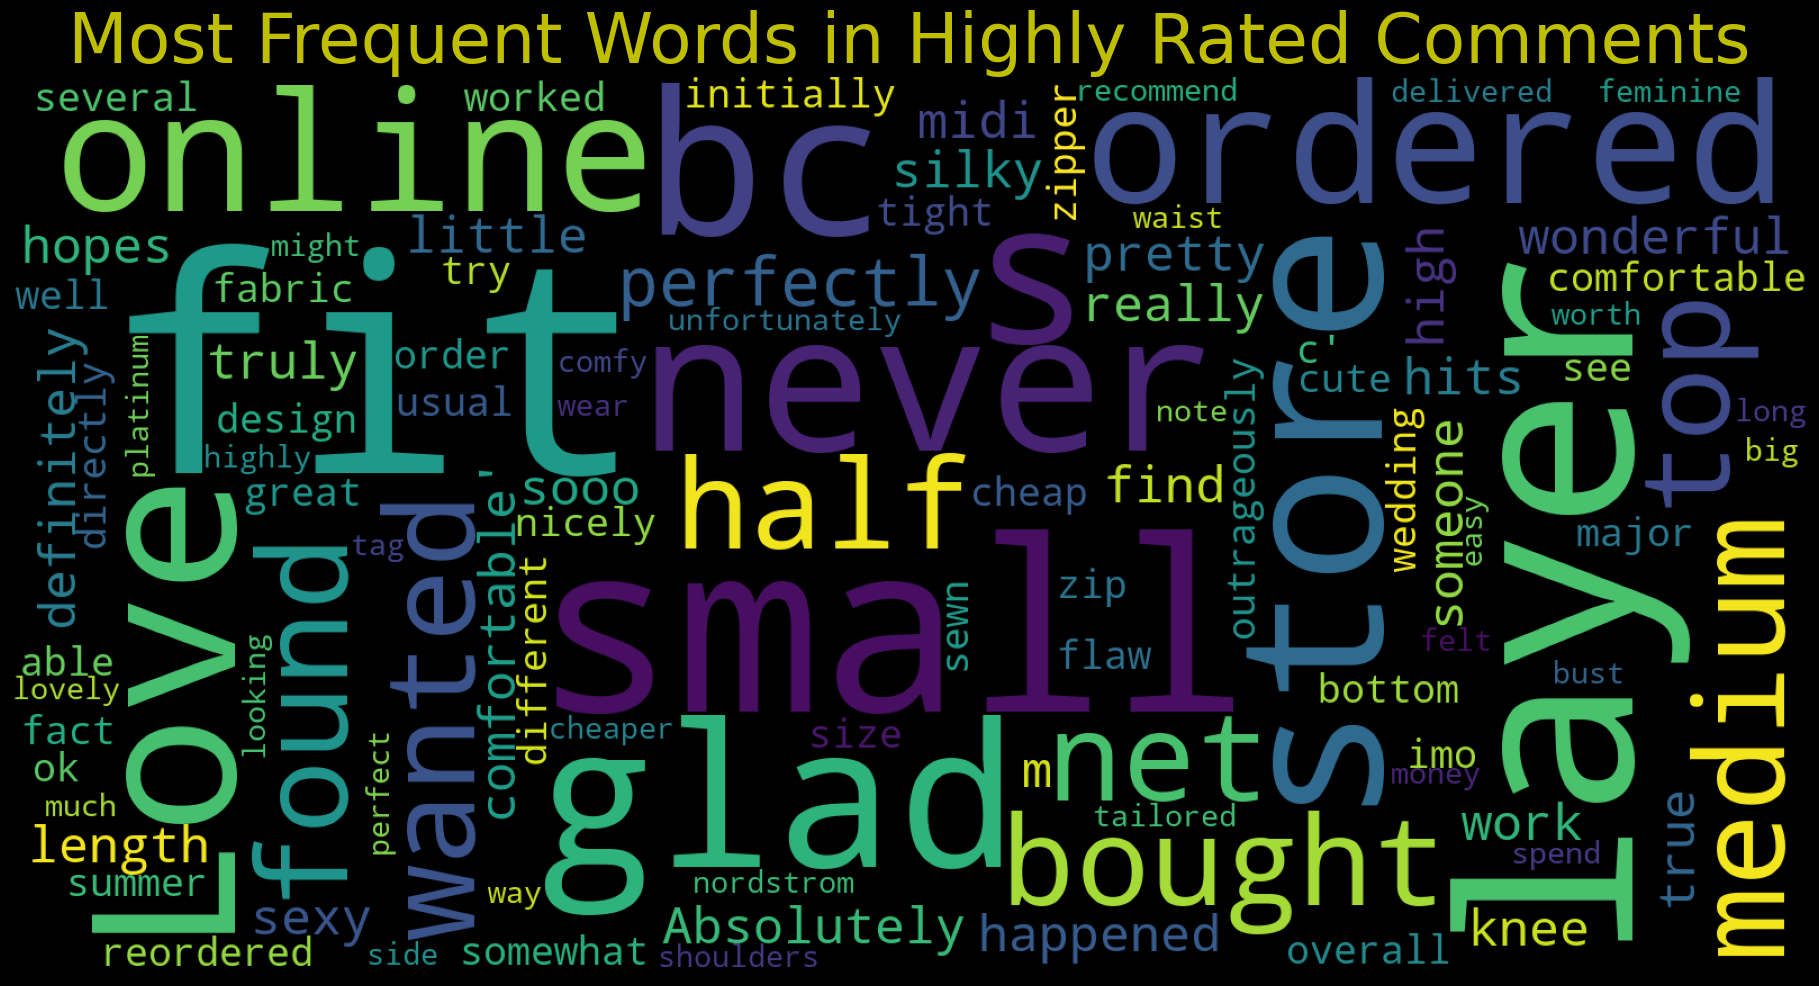

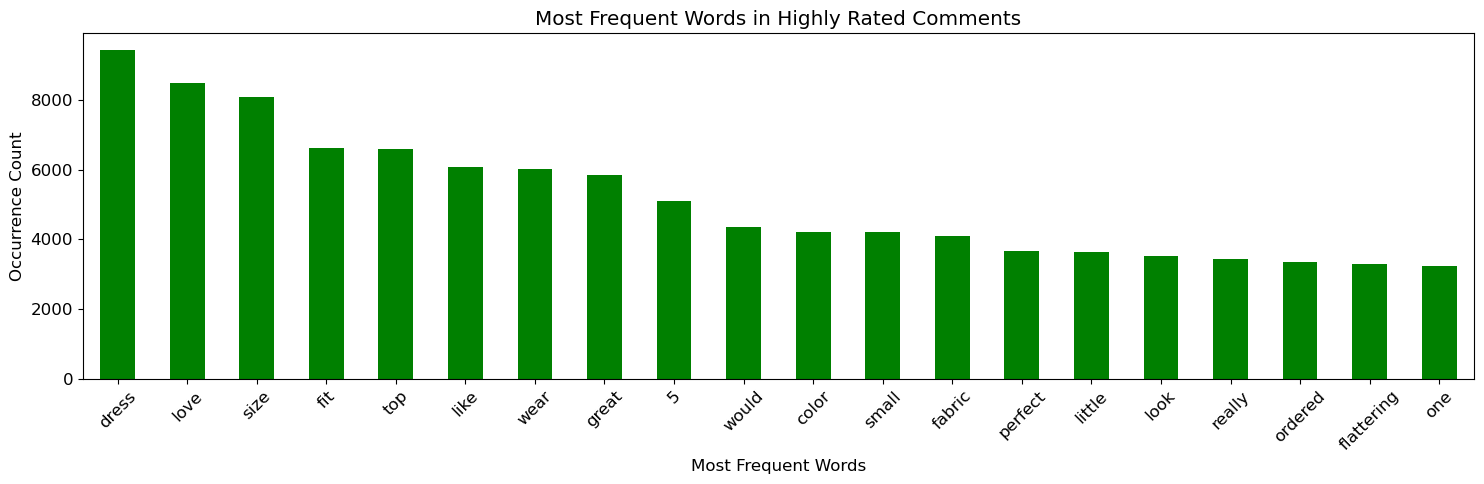

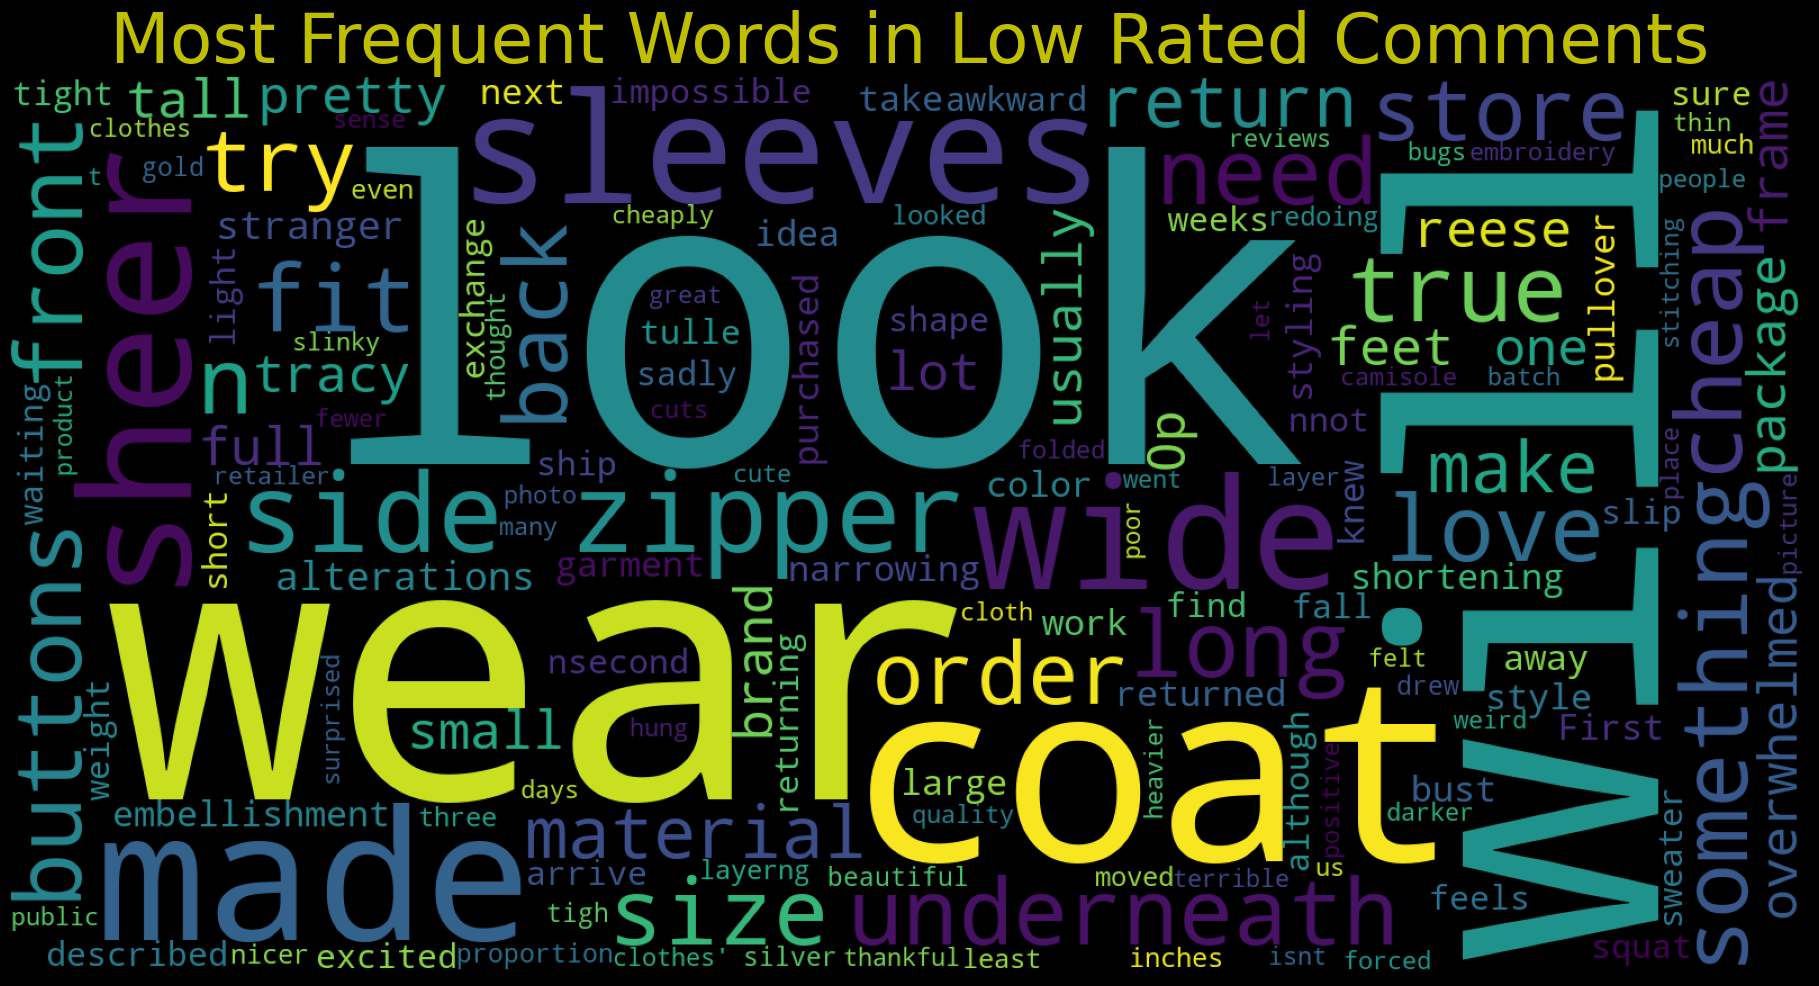

In [43]:
title ='Most Frequent Words in Highly Rated Comments'
temp = df['Review Text'][df.Rating.astype(int) >= 3]

# Modify Stopwords to Exclude Class types, suchs as 'dress'
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df['Class Name'][df['Class Name'].notnull()].unique())]
                + ['dress', 'petite'])

# Cloud
cloud(text= temp.values, title=title,stopwords= new_stop)

# Bar Chart
wordfreq(preprocessing(temp), 20).plot.bar(rot=45, legend=False, figsize=(15, 5), color='g',
                                          title=title)
plt.ylabel('Occurrence Count')
plt.xlabel('Most Frequent Words')
plt.tight_layout()
plt.savefig('most-freq-words-high-rate-comments.png', format='png', dpi=300)
plt.show()

# Low Raited
title ='Most Frequent Words in Low Rated Comments'
temp = df['Review Text'][df.Rating.astype(int) < 3]

# Modify Stopwords to Exclude Class types, suchs as 'dress'
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df['Class Name'][df['Class Name'].notnull()].unique())]
                + ['dress', 'petite', 'skirt', 'shirt'])

# Cloud
cloud(temp.values, title=title, stopwords=new_stop)

## WordClouds by Department Name

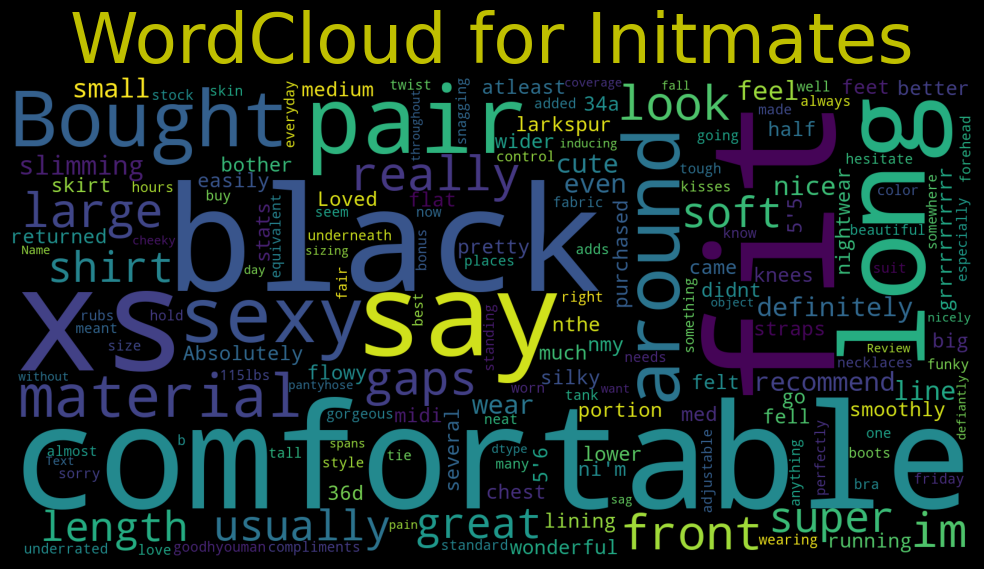

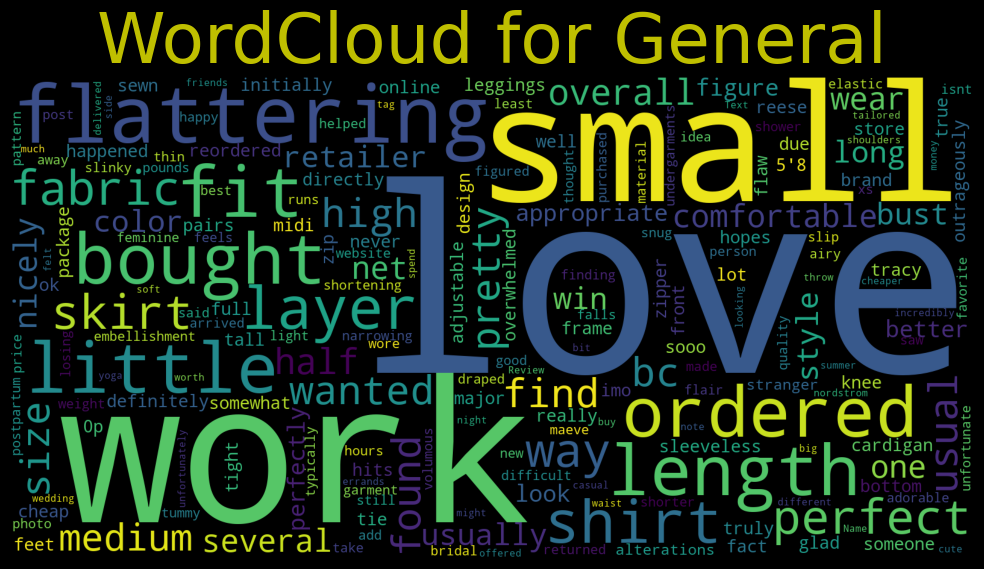

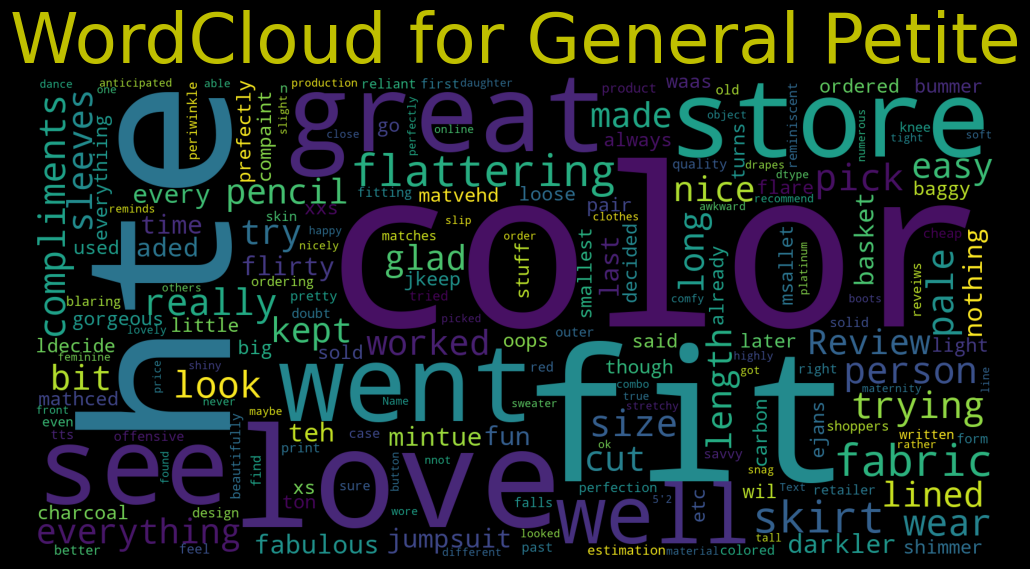

In [44]:
department_set = df['Department Name'][df['Department Name'].notnull()].unique()
division_set = df['Division Name'][df['Division Name'].notnull()].unique()
def cloud_by_category(data, category, subclass):
    """Function to create a wordcloud by class and subclass
    Category signifies the column variable
    Subclass refers to the specific value within the categorical variable"""
    new_stop = set(STOPWORDS)
    new_stop.update([x.lower() for x in list(data['Class Name'][data['Class Name'].notnull()].unique())]
                   + [x.lower() for x in list(data['Department Name'][data['Department Name'].notnull()].unique())]
                   + ['dress', 'petite', 'jacket', 'top'])

    # Cloud
    cloud(text= data['Review Text'][data[category]== subclass],
          title='WordCloud for {}'.format(subclass),
          stopwords= new_stop,
          size = (10,6))
    
# Plot
cloud_by_category(df, 'Division Name', division_set[0])
cloud_by_category(df, 'Division Name', division_set[1])
cloud_by_category(df, 'Division Name', division_set[2])

# Supervised Learning

## Recommended IND Classification

In [45]:
reviews = df['Review Text'].astype(str).str.lower()

In [46]:
type(reviews)

pandas.core.series.Series

In [47]:
features = reviews.tolist()

In [48]:
features

['absolutely wonderful - silky and sexy and comfortable',
 'love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
 'i had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
 "i love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments

In [49]:
import re
from string import punctuation

In [50]:
for index in range(len(features)):
    all_text = ''.join([character for character in features[index] if character not in punctuation])
    features[index] = re.split(r'\n|\r', all_text)
    features[index] = ' '.join([word for word in features[index]])

In [51]:
features

['absolutely wonderful  silky and sexy and comfortable',
 'love this dress  its sooo pretty  i happened to find it in a store and im glad i did bc i never would have ordered it online bc its petite  i bought a petite and am 58  i love the length on me hits just a little below the knee  would definitely be a true midi on someone who is truly petite',
 'i had such high hopes for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reordered it in petite medium which was just ok overall the top half was comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layers imo a major design flaw was the net over layer sewn directly into the zipper  it c',
 'i love love love this jumpsuit its fun flirty and fabulous every time i wear it i get nothing but great compliments',
 'this shirt is very flattering to al

In [52]:
labels = np.array(df['Recommended IND'], int)

In [53]:
labels.shape

(22628,)

In [54]:
labels[labels == 1].shape[0]

18527

In [55]:
labels[labels == 0].shape[0]

4101

In [56]:
from keras.utils import to_categorical

In [57]:
labels = to_categorical(labels)

In [58]:
labels[:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [59]:
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [60]:
t = Tokenizer()
t.fit_on_texts(features)
vocabulary_size = len(t.word_index) + 1

In [61]:
print('Vocabulary size : {}'.format(vocabulary_size))

Vocabulary size : 19370


In [62]:
encoded_features = t.texts_to_sequences(features)

max_length = 300

padded_features = pad_sequences(encoded_features, maxlen=max_length, padding='post')

In [64]:
embeddings_index = dict()
with open('glove.840B.300d.test.txt', encoding='utf8') as file:
    data = file.readlines()
    
# store <key, value> pair of FastText vectors
for line in data[1:]:
    word, vec = line.split(' ', 1)
    embeddings_index[word] = np.array([float(index) for index in vec.split()], dtype='float32')
print('Loaded {} word vectors.'.format(len(embeddings_index)))


embedding_matrix = np.zeros((vocabulary_size, max_length))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 2196016 word vectors.


In [65]:
words = []
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        words.append(word)

In [66]:
print('{} words covered.'.format(len(words)))

13911 words covered.


In [67]:
percentage = (len(words) / vocabulary_size) * 100.00
print('{}% of {} words were covered'.format(percentage, vocabulary_size))

71.81724315952503% of 19370 words were covered


In [68]:
def train_test_split(features, labels, **kwargs):
    
    # concatenate the features and labels array
    dataset = np.c_[features, labels]

    # shuffle the dataset
    np.random.shuffle(dataset)

    # split the dataset into features, labels
    features, labels = dataset[:, 0:max_length], dataset[:, max_length:]

    # get the split size for training dataset
    split_index = int(kwargs['train_size'] * len(features))

    # split the dataset into training/validation dataset
    train_features, validation_features = features[:split_index], features[split_index:]
    train_labels, validation_labels = labels[:split_index], labels[split_index:]

    # get the split size for validation dataset
    split_index = int(kwargs['validation_size'] * len(validation_features))

    # split the validation dataset into validation/testing dataset
    validation_features, test_features = validation_features[:split_index], validation_features[split_index:]
    validation_labels, test_labels = validation_labels[:split_index], validation_labels[split_index:]

    # return the partitioned dataset
    return [train_features, train_labels], [validation_features, validation_labels], [test_features, test_labels]

In [69]:
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.60, validation_size=0.50)

In [70]:
print('Dataset size : {}'.format(padded_features.shape[0]))
print('Train dataset size : {}'.format(train_dataset[0].shape[0]))
print('Validation dataset size : {}'.format(validation_dataset[0].shape[0]))
print('Test dataset size : {}'.format(test_dataset[0].shape[0]))

Dataset size : 22628
Train dataset size : 13576
Validation dataset size : 4526
Test dataset size : 4526


In [71]:
from keras import callbacks
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold

In [72]:
model = Sequential()
e = Embedding(vocabulary_size, max_length,
              weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.50))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_dataset[0], train_dataset[1], epochs=32, batch_size=256, verbose=1,
          validation_data=(validation_dataset[0], validation_dataset[1]))

score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

print('loss : {}, acc : {}'.format(score[0], score[1]))

Epoch 1/32
54/54 [==============================] - 456s 7s/step - loss: 0.4475 - accuracy: 0.8203 - val_loss: 0.4043 - val_accuracy: 0.7857
Epoch 2/32
54/54 [==============================] - 384s 7s/step - loss: 0.3426 - accuracy: 0.8389 - val_loss: 0.4017 - val_accuracy: 0.8537
Epoch 3/32
54/54 [==============================] - 381s 7s/step - loss: 0.3195 - accuracy: 0.8542 - val_loss: 0.3225 - val_accuracy: 0.8615
Epoch 4/32
54/54 [==============================] - 379s 7s/step - loss: 0.3020 - accuracy: 0.8687 - val_loss: 0.2956 - val_accuracy: 0.8650
Epoch 5/32
54/54 [==============================] - 379s 7s/step - loss: 0.2713 - accuracy: 0.8802 - val_loss: 0.2905 - val_accuracy: 0.8712
Epoch 6/32
54/54 [==============================] - 391s 7s/step - loss: 0.2597 - accuracy: 0.8877 - val_loss: 0.2622 - val_accuracy: 0.8884
Epoch 7/32
54/54 [==============================] - 384s 7s/step - loss: 0.2463 - accuracy: 0.8968 - val_loss: 0.2562 - val_accuracy: 0.8924
Epoch 8/32
54

In [73]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_dataset[0])
test_predictions = np.argmax(test_predictions, axis=1)

class_names = ['(0) Not recommended class', '(1) Recommended class']
report = classification_report(np.argmax(test_dataset[1], axis=1), test_predictions, target_names=class_names)

142/142 [==============================] - 60s 408ms/step


In [74]:
print(report)

                           precision    recall  f1-score   support

(0) Not recommended class       0.50      0.77      0.61       808
    (1) Recommended class       0.94      0.83      0.89      3718

                 accuracy                           0.82      4526
                macro avg       0.72      0.80      0.75      4526
             weighted avg       0.87      0.82      0.84      4526



In [75]:
conf_matrix = confusion_matrix(np.argmax(test_dataset[1], axis=1), test_predictions)
print(conf_matrix)

[[ 625  183]
 [ 620 3098]]


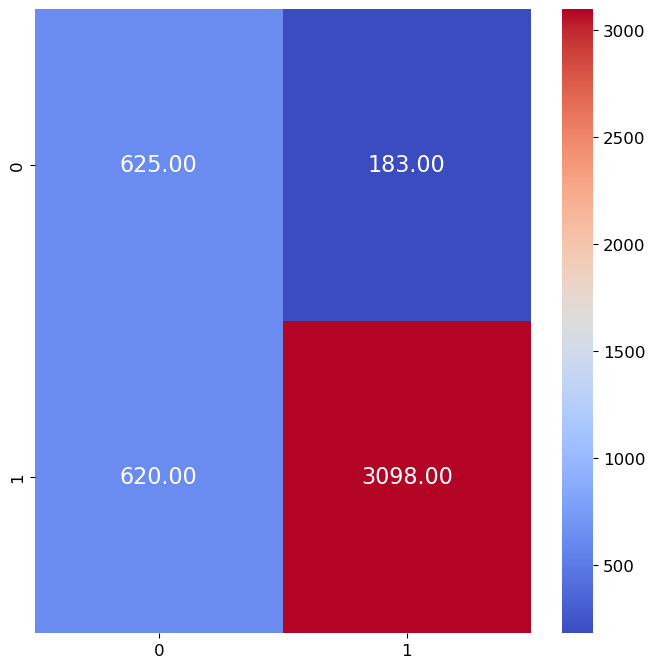

In [76]:
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')
plt.savefig('conf_matrix_recommendation.png', format='png', dpi=300)

In [77]:
from sklearn.metrics import roc_auc_score

roc = roc_auc_score(y_score=test_predictions, y_true=np.argmax(test_dataset[1], 1))
print(roc)

0.803379265441337


In [78]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(np.argmax(test_dataset[1], 1), test_predictions)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.803379265441337


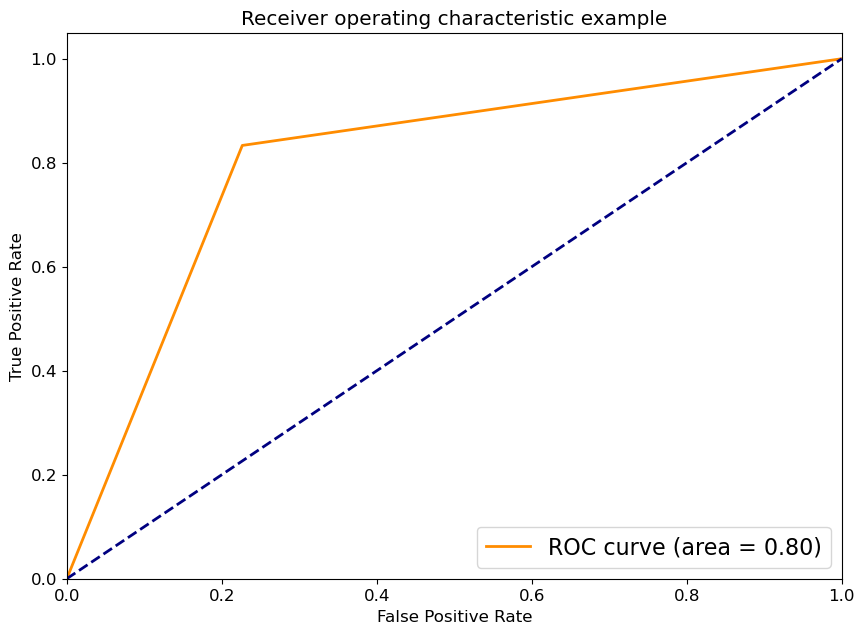

In [79]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, lw=2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right', fontsize=16)
plt.savefig('roc.png', format='png', dpi=300)
plt.show()

## Sentiment Classification

In [80]:
labels = np.array(df['Sentiment'])

In [81]:
labels

array(['Positive', 'Positive', 'Positive', ..., 'Positive', 'Positive',
       'Positive'], dtype=object)

In [83]:
labels = np.array([2 if label == 'Positive' else (1 if label == 'Neutral' else 0) for label in labels],
                  int)

In [84]:
labels

array([2, 2, 2, ..., 2, 2, 2])

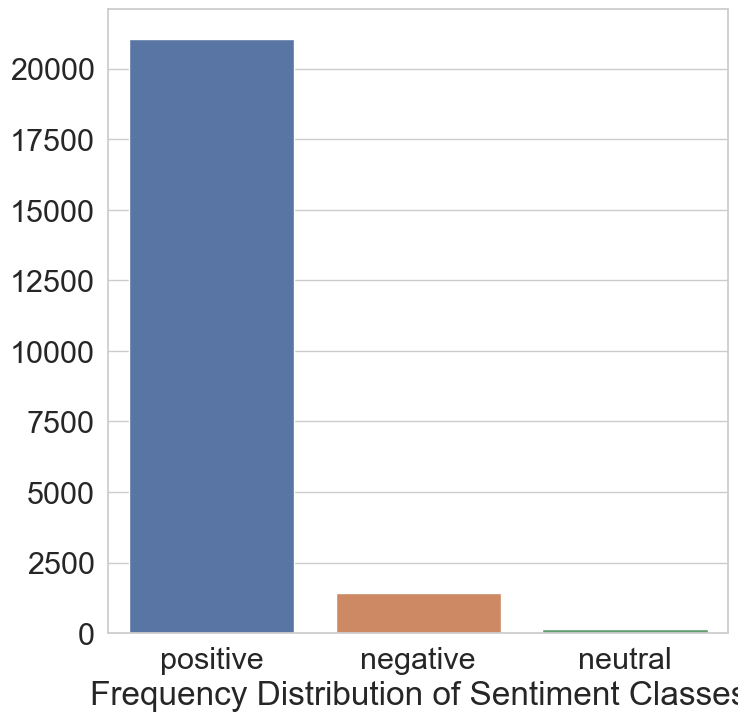

In [85]:
positive_class = int(labels[labels == 2].shape[0])
neutral_class = int(labels[labels == 1].shape[0])
negative_class = int(labels[labels == 0].shape[0])

df = pd.DataFrame.from_dict({'positive': [positive_class], 'negative': [negative_class], 'neutral': [neutral_class]})

plt.figure(figsize=(8, 8))
sns.set(font_scale=2)
sns.set_style('whitegrid')
ax = sns.barplot(data=df)
ax = ax.set_xlabel('Frequency Distribution of Sentiment Classes')

In [86]:
labels = to_categorical(labels)

In [87]:
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.60, validation_size=0.50)

In [88]:
model = Sequential()
e = Embedding(vocabulary_size, max_length,
              weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(256), merge_mode='sum'))
model.add(Dropout(0.50))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_dataset[0], train_dataset[1], epochs=32, batch_size=256, verbose=1,
          validation_data=(validation_dataset[0], validation_dataset[1]))

score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

print('loss : {}, acc : {}'.format(score[0], score[1]))

Epoch 1/32
54/54 [==============================] - 486s 9s/step - loss: 0.2981 - accuracy: 0.9193 - val_loss: 0.2705 - val_accuracy: 0.9264
Epoch 2/32
54/54 [==============================] - 388s 7s/step - loss: 0.2527 - accuracy: 0.9314 - val_loss: 0.2431 - val_accuracy: 0.9264
Epoch 3/32
54/54 [==============================] - 385s 7s/step - loss: 0.2346 - accuracy: 0.9311 - val_loss: 0.2767 - val_accuracy: 0.9266
Epoch 4/32
54/54 [==============================] - 385s 7s/step - loss: 0.2287 - accuracy: 0.9319 - val_loss: 0.2206 - val_accuracy: 0.9282
Epoch 5/32
54/54 [==============================] - 385s 7s/step - loss: 0.2002 - accuracy: 0.9341 - val_loss: 0.2034 - val_accuracy: 0.9308
Epoch 6/32
54/54 [==============================] - 386s 7s/step - loss: 0.1933 - accuracy: 0.9361 - val_loss: 0.2438 - val_accuracy: 0.9191
Epoch 7/32
54/54 [==============================] - 382s 7s/step - loss: 0.1899 - accuracy: 0.9362 - val_loss: 0.1974 - val_accuracy: 0.9322
Epoch 8/32
54

In [96]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_dataset[0])
test_predictions = np.argmax(test_predictions, axis=1)

class_names = ['(0) Negative class', '(1) Neutral class', '(2) Positive class']
report = classification_report(np.argmax(test_dataset[1], axis=1), test_predictions, target_names=class_names)

142/142 [==============================] - 92s 649ms/step


In [95]:
print(report)

                    precision    recall  f1-score   support

(0) Negative class       0.46      0.54      0.50       290
 (1) Neutral class       0.35      0.39      0.37        23
(2) Positive class       0.97      0.95      0.96      4213

          accuracy                           0.93      4526
         macro avg       0.59      0.63      0.61      4526
      weighted avg       0.93      0.93      0.93      4526



In [94]:
conf_matrix = confusion_matrix(np.argmax(test_dataset[1], axis=1), test_predictions)
print(conf_matrix)

[[ 158    8  124]
 [   5    9    9]
 [ 182    9 4022]]


<AxesSubplot: >

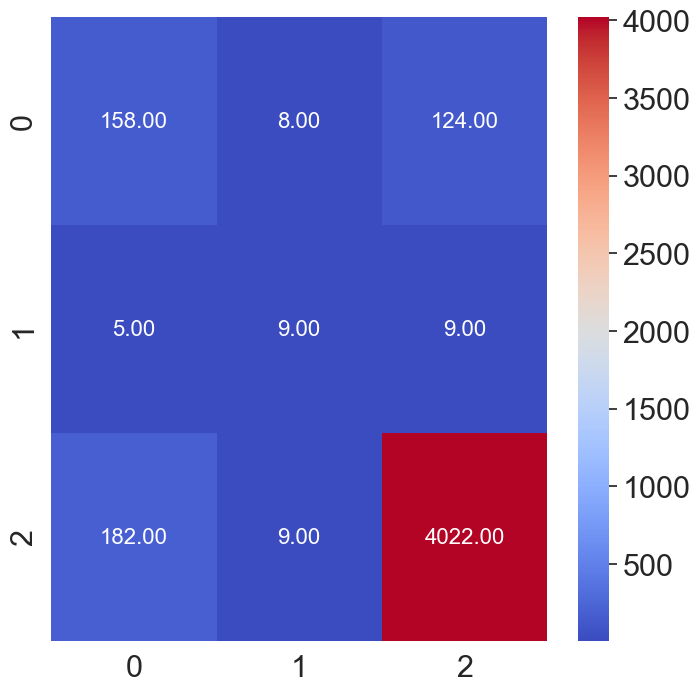

In [93]:
plt.figure(figsize=(8, 8))
plt.savefig('conf_matrix_sentiment.png', format='png', dpi=300)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')